In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Импортируем dataframe, полученный по результатам парсинга исходных данных

In [104]:
df = pd.read_csv('/content/drive/MyDrive/EKG/ecg_features_final.csv', low_memory=False)

По результатам парсинга некорректно обработан признак'scp_codes_raw'.
Необходимо выполнить заново обработку этого признака.
Далее удаляем старые scp признаки

In [105]:
print(df.shape)
for col_name in df.columns:
    if 'scp' in col_name and col_name != 'scp_codes_raw':
        df = df.drop(col_name, axis=1)
print(df.shape)
print(df['scp_codes_raw'].unique())

(9793, 955)
(9793, 458)
["{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}" "{'NORM': 80.0, 'SBRAD': 0.0}"
 "{'NORM': 100.0, 'SR': 0.0}" ...
 "{'ASMI': 15.0, 'CRBBB': 100.0, 'LAFB': 100.0, 'QWAVE': 0.0, 'SR': 0.0}"
 "{'NDT': 100.0, 'STD_': 0.0, 'NT_': 0.0, 'SR': 0.0}"
 "{'LVH': 15.0, 'NDT': 100.0, 'LOWT': 0.0, 'SR': 0.0}"]


Для расшифровки SCP кодом используем ГОСТ Р ИСО 11073-91064-2017

Ссылка: https://files.stroyinf.ru/Data2/1/4293740/4293740830.pdf?ysclid=mhd9rmonsz770858723

In [106]:
# Список кодов для аритмии (нарушения ритма и проводимости)
arrhythmia_codes = [
    # Нарушения ритма
    'SR', 'NSR', 'SARRH', 'MSAR', 'SVARR', 'STACH', 'ETACH', 'SBRAD', 'EBRAD',
    'JTACH', 'SVTAC', 'JBRAD', 'SVBRA', 'WQTAC', 'NQTAC', 'TACHO', 'BRADO',
    'ARRHY', 'IRREG', 'REGRH', 'JESCR', 'VESCR', 'ACAR', 'ACVR', 'ACJR',
    'AVJR', 'ARHYT', 'SVRHY', 'JRHYT', 'VRHYT', 'UNRHY', 'EAR', 'LAR', 'MAR',
    'NODRH', 'RAR', 'LGL', 'SHTPR', 'AFIB', 'AFLT', 'ATACH', 'PSVT', 'PAT',
    'MFAT', 'RATAC', 'RJTAC', 'AVNRT', 'AVRT', 'IDIOR', 'VFIB', 'VTACH',
    'RVTAC', 'SVT', 'NSVT', 'TORSA', 'MTACH', 'VFLT', 'ASYST',

    # Нарушения проводимости и блокады
    '1AVB', '2AVB', '3AVB', 'I2AVB', 'A2AVB', 'AVDIS', 'WENCK', 'MOBI2',
    'SAR', 'SARA', 'SARSV', 'SARJ', 'SARV', 'SABLK', 'SPAUS', 'WANDP',
    'LRR', 'OCAP',

    # Экстрасистолы и преждевременные комплексы
    'PRC(S)', 'PAC', 'APC', 'BAPCS', 'MAPCS', 'PVC', 'VPC', 'MVPCS', 'RVPCS',
    'RPVCS', 'RAPCS', 'RJPCS', 'VIC', 'MVICS', 'MICS', 'SVPC', 'SVPCS',
    'SVIC(S)', 'ABER(S)', 'ABPCS', 'ABSVC', 'ABSVS', 'ABASH', 'JPC(S)',
    'MJPCS', 'PVPCS', 'PPVCS', 'PAPCS', 'PJPCS', 'OVPAC', 'ONPAC', 'VBIG',
    'ABIG', 'SVBIG', 'BIGU', 'FUSC(S)', 'CAPT(S)', 'VEC(S)', 'AEC(S)',
    'SVEC(S)', 'JEC(S)', 'ESCUN', 'VPARA', 'APARA', 'VTRIG', 'ATRIG',
    'SVTRI', 'TRIGU', 'VQUAG', 'RECIP',

    # Блокады ножек пучка Гиса
    'BBB', 'CLBBB', 'ILBBB', 'ALBBB', 'CRBBB', 'IRBBB', 'IVCD', 'IVCD>',
    'IVCD<', 'WPW', 'WPWA', 'WPWB', 'PREEX', 'LAFB', 'LPFB', 'BIFAS', 'TRFAS',

    # Кардиостимуляция
    'PACE', 'PACEA', 'PACEP', 'PACEF', 'PACED', 'PACEM', 'EPAVS', 'EPVC',
    'EPDM', 'EPFC', 'EPFS', 'EPARV', 'EPU', 'EPURV', 'PAA', 'PAD', 'PAVA',
    'PAD', 'EM', 'OVPAC', 'ONPAC'
]

# Список кодов для инфаркта миокарда
infarction_codes = [
    'MI', 'AMI', 'ASMI', 'ALMI', 'LMI', 'HLMI', 'APMI', 'IMI', 'ILMI',
    'IPMI', 'IPLMI', 'PMI', 'QWAVE', 'MYOIN'
]

# Список кодов для ишемии и повреждения миокарда
ischemia_codes = [
    # Ишемические изменения
    'ISC_', 'ISCAN', 'ISCAL', 'ISCIN', 'ISCAS', 'ISCLA', 'ISCPO', 'ISCIP',
    'ISCIL', 'ISCAF', 'ISCWI', 'ISCDI', 'ISDIG',

    # Субэндокардиальное повреждение
    'INJ_', 'INJAN', 'INJAL', 'INJIN', 'INJAS', 'INJLA', 'INJPO', 'INJIP',
    'INJIL', 'INJAF', 'INJWI', 'INJDI',

    # Субэпикардиальное повреждение
    'EPI_', 'EPIAN', 'EPIAL', 'EPIIN', 'EPIAS', 'EPILA', 'EPIPO', 'EPIIP',
    'EPIIL', 'EPIAF', 'EPIWI', 'EPIDI'
]

# Список кодов для гипертрофии
hypertrophy_codes = [
    'LVH', 'VCLVH', 'RVH', 'VCRVH', 'BVH', 'SEHYP', 'PRANT'
]

# Список кодов для изменений ST-T
stt_changes_codes = [
    'STT_', 'NST_', 'STE_', 'STD_', 'TAB_', 'NT_', 'NDT', 'TNOR', 'DIG',
    'FITVOL', 'QUIN', 'PERIC', 'STVAG', 'LNGQT', 'SFITQT', 'HIGFIT', 'LOWT',
    'INVT', 'HPOCA', 'FIPOK', 'HPRCA', 'FIPRK', 'STDJ', 'REPOL', 'ANEUR',
    'POSTO', 'PULM', 'ACET', 'NDOC', 'METAB', 'IBP', 'CONG', 'VALV', 'RESP',
    'JUV', 'CUN', 'STNOR', 'STPAC', 'STPVC'
]

# Список кодов для нормальных и пограничных состояний
normal_codes = [
    'NORM', 'NLECG', 'NLQRS', 'NLP', 'NLSTT', 'WHNOR', 'POSNL', 'BOECG',
    'ABECG', 'POSAB', 'ABQRS', 'ABSTT', 'NFA', 'NFB', 'ABFA', 'ABFB', 'UFB'
]

# Список кодов для предсердных изменений
atrial_codes = [
    'LAO/LAE', 'RAO/RAE', 'BAO/BAE', 'IACD', 'HPVOL', 'NSPEP', 'ABRAX', 'UNPAX'
]

Пример расшифровки scp_codes_raw

Пример 1: "{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
100% вероятность нормальной ЭКГ, исключает низкий вольтаж и синусовый ритм

Пример 2: "{'NORM': 80.0, 'SBRAD': 0.0}"
Вероятность нормальной ЭКГ - 80%, синусовая брадикардия исключена

Пример 3: "{'ASMI': 15.0, 'CRBBB': 100.0, 'LAFB': 100.0, 'QWAVE': 0.0, 'SR': 0.0}"
Полная блокада ПНПГ - 100%
Блокада передней ветви ЛНПГ - 100%  
Передне-перегородочный инфаркт - низкая вероятность (15%)
Q-зубцы и синусовый ритм исключены

In [107]:
import ast

df['target_norm'] = 0
df['target_arrhythmia'] = 0
df['target_infarction'] = 0
df['target_norm_probability'] = 0.0
df['target_arrhythmia_probability'] = 0.0
df['target_infarction_probability'] = 0.0
df['arrhythmia_codes'] = np.nan
df['infarction_codes'] = np.nan

for index, row in df.iterrows():
    scp_string = row['scp_codes_raw']
    scp_dict = ast.literal_eval(scp_string)
    for scp_code in scp_dict:
        probability = float(scp_dict[scp_code])
        if scp_code == 'NORM' and probability != 0.0:
            df.at[index, 'target_norm'] = 1
            df.at[index, 'target_norm_probability'] = scp_dict[scp_code]
        elif scp_code in arrhythmia_codes and probability != 0.0:
            df.at[index, 'target_arrhythmia'] = 1
            df.at[index, 'target_arrhythmia_probability'] = max(probability, df.at[index, 'target_arrhythmia_probability'])

            current = df.at[index, 'arrhythmia_codes']
            if not isinstance(current, list):
                df.at[index, 'arrhythmia_codes'] = [scp_code]
            else:
                df.at[index, 'arrhythmia_codes'] = current + [scp_code]

        elif scp_code in infarction_codes and probability != 0.0:
            df.at[index, 'target_infarction'] = 1
            df.at[index, 'target_infarction_probability'] = max(probability, df.at[index, 'target_arrhythmia_probability'])

            current = df.at[index, 'infarction_codes']
            if not isinstance(current, list):
                df.at[index, 'infarction_codes'] = [scp_code]
            else:
                df.at[index, 'infarction_codes'] = current + [scp_code]
print(df[['scp_codes_raw', 'target_norm', 'target_norm_probability', 'target_arrhythmia', 'target_arrhythmia_probability', 'target_infarction', 'target_infarction_probability', 'arrhythmia_codes', 'infarction_codes']])


/tmp/ipython-input-3139577402.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IMI' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'infarction_codes'] = [scp_code]
/tmp/ipython-input-3139577402.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AFLT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'arrhythmia_codes'] = [scp_code]


                                            scp_codes_raw  target_norm  target_norm_probability  target_arrhythmia  target_arrhythmia_probability  target_infarction  target_infarction_probability arrhythmia_codes infarction_codes
0                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}            1                    100.0                  0                            0.0                  0                            0.0              NaN              NaN
1                            {'NORM': 80.0, 'SBRAD': 0.0}            1                     80.0                  0                            0.0                  0                            0.0              NaN              NaN
2                              {'NORM': 100.0, 'SR': 0.0}            1                    100.0                  0                            0.0                  0                            0.0              NaN              NaN
3                              {'NORM': 100.0, 'SR': 0.0}            1          

Оценим распределение верояности положительных значений таргетных переменных

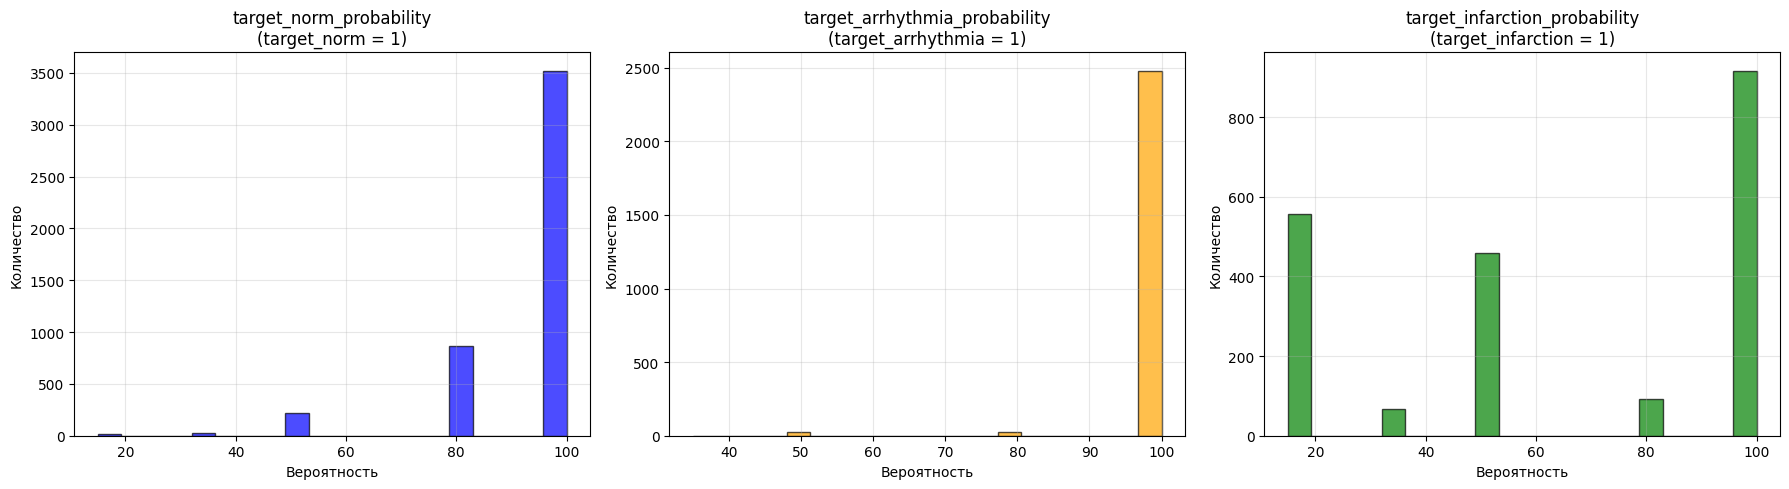

In [108]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# target_norm_probability при target_norm = 1
axes[0].hist(df[df['target_norm'] == 1]['target_norm_probability'],
             bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Вероятность')
axes[0].set_ylabel('Количество')
axes[0].set_title('target_norm_probability\n(target_norm = 1)')
axes[0].grid(True, alpha=0.3)

# target_arrhythmia_probability при target_arrhythmia = 1
axes[1].hist(df[df['target_arrhythmia'] == 1]['target_arrhythmia_probability'],
             bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_xlabel('Вероятность')
axes[1].set_ylabel('Количество')
axes[1].set_title('target_arrhythmia_probability\n(target_arrhythmia = 1)')
axes[1].grid(True, alpha=0.3)

# target_infarction_probability при target_infarction = 1
axes[2].hist(df[df['target_infarction'] == 1]['target_infarction_probability'],
             bins=20, alpha=0.7, color='green', edgecolor='black')
axes[2].set_xlabel('Вероятность')
axes[2].set_ylabel('Количество')
axes[2].set_title('target_infarction_probability\n(target_infarction = 1)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Для минимизации ложноотрицательных прогнозов при вероятности для target_norm = 1 меньше 60% будем считать экг патологией

In [109]:
# Находим строки где target_norm_probability < 60
mask = df['target_norm_probability'] < 60

# Присваиваем target_norm = 0 для этих строк
df.loc[mask, 'target_norm'] = 0

print(f"Исправлено строк: {mask.sum()}")

Исправлено строк: 5404


In [110]:
df['target_norm_probability'] = 1

Анализируем наличие попарных пересечений

In [111]:
# Попарные комбинации
from itertools import combinations

target_cols = ['target_norm', 'target_arrhythmia', 'target_infarction', ]

for col1, col2 in combinations(target_cols, 2):
    cross_tab = pd.crosstab(df[col1], df[col2])
    print(f"\nПересечение {col1} и {col2}:")
    print(cross_tab)
    print(f"Совпадений: {((df[col1] == 1) & (df[col2] == 1)).sum()}")


Пересечение target_norm и target_arrhythmia:
target_arrhythmia     0     1
target_norm                  
0                  3038  2366
1                  4222   167
Совпадений: 167

Пересечение target_norm и target_infarction:
target_infarction     0     1
target_norm                  
0                  3310  2094
1                  4389     0
Совпадений: 0

Пересечение target_arrhythmia и target_infarction:
target_infarction     0     1
target_arrhythmia            
0                  5969  1291
1                  1730   803
Совпадений: 803


In [112]:
arrhythmia_set = set(
    df.loc[
        (df['target_norm'] == 1) &
        (df['target_arrhythmia'] == 1),
        'arrhythmia_codes'
    ].explode().dropna()
)

print("SCP коды аритмии, при которых 'ЭКГ считается нормальным:")
print(arrhythmia_set)

SCP коды аритмии, при которых 'ЭКГ считается нормальным:
{'1AVB', 'IRBBB', 'IVCD', 'PAC', 'LPFB', 'LAFB', 'PVC'}


# **Имеются конфликты при которых target_norm и target_arrhythmia равны 1**

# **Это присходит при следующих SCP кодах:**

IRBBB (неполная блокада ПНПГ) - часто встречается у здоровых людей, особенно молодых

IVCD (неспецифическое нарушение проводимости) - может быть вариантом нормы

PVC, PAC (экстрасистолы) - единичные могут быть у здоровых людей

1AVB (AV-блокада 1 степени) - часто не требует лечения если бессимптомное

LAFB, LPFB (блокады ветвей) - могут быть изолированными находками

# *Так как это незначительные патологии, при подобном конфликте будем считать ЭКГ нормальным*

In [113]:
mask = (df['target_norm'] == 1) & (df['target_arrhythmia'] == 1)
df.loc[mask, 'target_arrhythmia'] = 0

print(f"Исправлено строк: {mask.sum()}")

Исправлено строк: 167


Анализ категориальных переменных

In [114]:
# Анализ типов данных всех колонок
print("Все типы данных в DataFrame:")
print(df.dtypes)
print("\n" + "="*50)

# Категориальные по типам
categorical_by_dtype = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Также можно включить булевы переменные
bool_columns = df.select_dtypes(include=['bool']).columns.tolist()

print("Категориальные переменные (object, category):")
print(categorical_by_dtype)
print(f"Найдено: {len(categorical_by_dtype)}")

print("\nБулевы переменные:")
print(bool_columns)
print(f"Найдено: {len(bool_columns)}")

# Все категориальные включая булевы
all_categorical = categorical_by_dtype + bool_columns
print(f"\nВсего категориальных переменных: {len(all_categorical)}")

Все типы данных в DataFrame:
I_meanRR                         float64
I_sdNN                           float64
I_RMSSD                          float64
I_pNN50                          float64
I_LF                             float64
                                  ...   
target_norm_probability            int64
target_arrhythmia_probability    float64
target_infarction_probability    float64
arrhythmia_codes                  object
infarction_codes                  object
Length: 466, dtype: object

Категориальные переменные (object, category):
['device', 'recording_date', 'report', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'filename_lr', 'filename_hr', 'scp_codes_raw', 'lead_names', 'arrhythmia_codes', 'infarction_codes']
Найдено: 18

Булевы переменные:
['V1_pathological_Q', 'V2_pathological_Q', 'V3_pathological_Q', 'V4_pathological_Q', 'V5_pathological_Q', 'V6_path

Исключим из категориальных признаков для анализа мета данные

In [115]:
categorical_columns = categorical_by_dtype
# Список колонок для исключения
columns_to_exclude = {
    'device',
    'recording_date',
    'report',
    'filename_lr',
    'filename_hr',
    'scp_codes_raw',
    'lead_names',
    'arrhythmia_codes',
    'infarction_codes'
}

# Фильтруем categorical_columns
categorical_columns = [col for col in categorical_columns if col not in columns_to_exclude]

In [116]:
df[categorical_columns]

,heart_axis,infarction_stadium1,infarction_stadium2,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker
0,NaN,NaN,NaN,NaN,", I-V1,",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,", II,III,AVF",NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
def analyze_categorical_columns(df, categorical_columns):
    analysis_results = {}

    for col in categorical_columns:
        if col not in df.columns:
            print(f"Колонка {col} не найдена в DataFrame")
            continue

        # Создаем копию колонки для анализа
        series = df[col].copy()

        # Подсчет различных типов значений
        total_count = len(series)
        nan_count = series.isna().sum()
        unknown_count = (series == 'unknown').sum()
        nan_unknown_count = nan_count + unknown_count

        # Проценты
        nan_percent = (nan_count / total_count) * 100
        unknown_percent = (unknown_count / total_count) * 100
        nan_unknown_percent = (nan_unknown_count / total_count) * 100

        # Уникальные значения (исключая NaN и 'unknown')
        unique_values = series.dropna()  # удаляем NaN
        unique_values = unique_values[unique_values != 'unknown']  # удаляем 'unknown'
        unique_count = unique_values.nunique()
        unique_list = unique_values.unique().tolist()

        analysis_results[col] = {
            'total_count': total_count,
            'nan_count': nan_count,
            'nan_percent': nan_percent,
            'unknown_count': unknown_count,
            'unknown_percent': unknown_percent,
            'nan_unknown_count': nan_unknown_count,
            'nan_unknown_percent': nan_unknown_percent,
            'unique_count': unique_count,
            'unique_values': unique_list
        }

    return analysis_results

# Использование функции
results = analyze_categorical_columns(df, categorical_columns)

for col, stats in results.items():
    print(f"\nПризнак: {col}")
    print(f"   Всего записей: {stats['total_count']}")
    print(f"   NaN: {stats['nan_count']} ({stats['nan_percent']:.2f}%)")
    print(f"   'unknown': {stats['unknown_count']} ({stats['unknown_percent']:.2f}%)")
    print(f"   NaN + 'unknown': {stats['nan_unknown_count']} ({stats['nan_unknown_percent']:.2f}%)")
    print(f"   Уникальных значений: {stats['unique_count']}")
    if stats['unique_values']:
        print(f"   Значения: {stats['unique_values']}")
    else:
        print(f"   Значения: []")


Признак: heart_axis
   Всего записей: 9793
   NaN: 4886 (49.89%)
   'unknown': 0 (0.00%)
   NaN + 'unknown': 4886 (49.89%)
   Уникальных значений: 7
   Значения: ['LAD', 'ALAD', 'RAD', 'AXR', 'MID', 'ARAD', 'AXL']

Признак: infarction_stadium1
   Всего записей: 9793
   NaN: 7561 (77.21%)
   'unknown': 1316 (13.44%)
   NaN + 'unknown': 8877 (90.65%)
   Уникальных значений: 4
   Значения: ['Stadium II-III', 'Stadium III', 'Stadium I', 'Stadium II']

Признак: infarction_stadium2
   Всего записей: 9793
   NaN: 9763 (99.69%)
   'unknown': 0 (0.00%)
   NaN + 'unknown': 9763 (99.69%)
   Уникальных значений: 3
   Значения: ['Stadium I', 'Stadium II', 'Stadium III']

Признак: baseline_drift
   Всего записей: 9793
   NaN: 8957 (91.46%)
   'unknown': 0 (0.00%)
   NaN + 'unknown': 8957 (91.46%)
   Уникальных значений: 215
   Значения: [' , II,III,AVF', ' , III,AVR,AVF', ' , V1', ' , II,AVF', ' , II-AVL,AVF', ' , V3', ' , III', ' , V6', ' , AVF', ' , II-AVF,V5,V6', ' , III,AVF', ' , II-AVF', ' , a

Проанализируем есть ли у нас конфликт между target_infarction и infarction_stadium1, infarction_stadium2

In [118]:
def check_infarction_contradictions(df):
    # Создаем маску для условий
    mask = (
        df['infarction_stadium1'].notna() &
        (~df['infarction_stadium1'].astype(str).str.lower().isin(['unknown', 'nan', 'none', ''])) &
        df['infarction_stadium2'].notna() &
        (~df['infarction_stadium2'].astype(str).str.lower().isin(['unknown', 'nan', 'none', ''])) &
        (df['target_infarction'] == 0)
    )

    conflicting_records = df[mask]

    return conflicting_records

# Использование функции
conflicting_df = check_infarction_contradictions(df)

print(f"Найдено записей: {len(conflicting_df)}")

if len(conflicting_df) > 0:
    print("\nДетальная информация:")
    print("Значения infarction_stadium1:")
    print(conflicting_df['infarction_stadium1'].value_counts())

    print("\nЗначения infarction_stadium2:")
    print(conflicting_df['infarction_stadium2'].value_counts())

    print("\nПримеры записей:")
    for idx, row in conflicting_df.head().iterrows():
        print(f"Index {idx}: stadium1='{row['infarction_stadium1']}', stadium2='{row['infarction_stadium2']}', target={row['target_infarction']}")

Найдено записей: 1

Детальная информация:
Значения infarction_stadium1:
infarction_stadium1
Stadium III    1
Name: count, dtype: int64

Значения infarction_stadium2:
infarction_stadium2
Stadium III    1
Name: count, dtype: int64

Примеры записей:
Index 858: stadium1='Stadium III', stadium2='Stadium III', target=0


In [119]:
# Проверка обратного случая
mask_reverse = (
    ((df['infarction_stadium1'].isna()) | (df['infarction_stadium1'] == 'unknown')) &
    ((df['infarction_stadium2'].isna()) | (df['infarction_stadium2'] == 'unknown')) &
    (df['target_infarction'] == 1)
)

reverse_conflicts = df[mask_reverse]
print(f"\nЗаписей с target_infarction=1, но пустыми stadium: {len(reverse_conflicts)}")


Записей с target_infarction=1, но пустыми stadium: 1214


Исправим для пободных конфликтов target_infarction

In [120]:
# Сначала посчитаем сколько записей мы исправим
mask_conflict = (
    df['infarction_stadium1'].notna() &
    (df['infarction_stadium1'] != 'unknown') &
    df['infarction_stadium2'].notna() &
    (df['infarction_stadium2'] != 'unknown') &
    (df['target_infarction'] == 0)
)

conflicting_count_before = len(df[mask_conflict])
print(f"Найдено противоречивых записей до исправления: {conflicting_count_before}")

# Исправляем target_infarction на 1 для этих записей
df.loc[mask_conflict, 'target_infarction'] = 1

# Проверяем результат
conflicting_count_after = len(df[
    df['infarction_stadium1'].notna() &
    (df['infarction_stadium1'] != 'unknown') &
    df['infarction_stadium2'].notna() &
    (df['infarction_stadium2'] != 'unknown') &
    (df['target_infarction'] == 0)
])

print(f"Противоречивых записей после исправления: {conflicting_count_after}")
print(f"Исправлено записей: {conflicting_count_before - conflicting_count_after}")

Найдено противоречивых записей до исправления: 1
Противоречивых записей после исправления: 0
Исправлено записей: 1


Проанализируем признак heart_axis на основе ГОСТ Р ИСО 11073-91064—2017

In [121]:
def categorize_heart_axis(value):
    """Категоризует отклонение электрической оси сердца по значимости"""
    # Критические отклонения
    critical_values = {'LAD', 'ALAD', 'RAD', 'ARAD'}

    # Умеренные отклонения
    medium_values = {'AXR', 'AXL'}

    # Нормальные значения
    normal_values = {'MID'}

    # Технические/вспомогательные
    technical_values = {'AXIND', 'AXSUP', 'AXPOS', 'AXVER', 'AXHOR', 'TRSLT', 'TRSRT', 'CCWRT', 'CWRT'}

    if pd.isna(value) or value == 'NaN':
        return np.nan
    elif value in critical_values:
        return 'critical'
    elif value in medium_values:
        return 'medium'
    elif value in normal_values:
        return 'normal'
    elif value in technical_values:
        # Для технических значений решаем на основе медицинской значимости
        # AXIND (ось не определяется) - считаем умеренным
        if value == 'AXIND':
            return 'medium'
        else:
            return np.nan
    else:
        # Для неизвестных значений возвращаем NaN
        return np.nan

# Создаем новый признак
df['heart_axis_cat'] = df['heart_axis'].apply(categorize_heart_axis)

# Проверяем результат
print("Распределение heart_axis_cat:")
print(df['heart_axis_cat'].value_counts(dropna=False))

Распределение heart_axis_cat:
heart_axis_cat
NaN         4886
normal      2744
critical    2078
medium        85
Name: count, dtype: int64


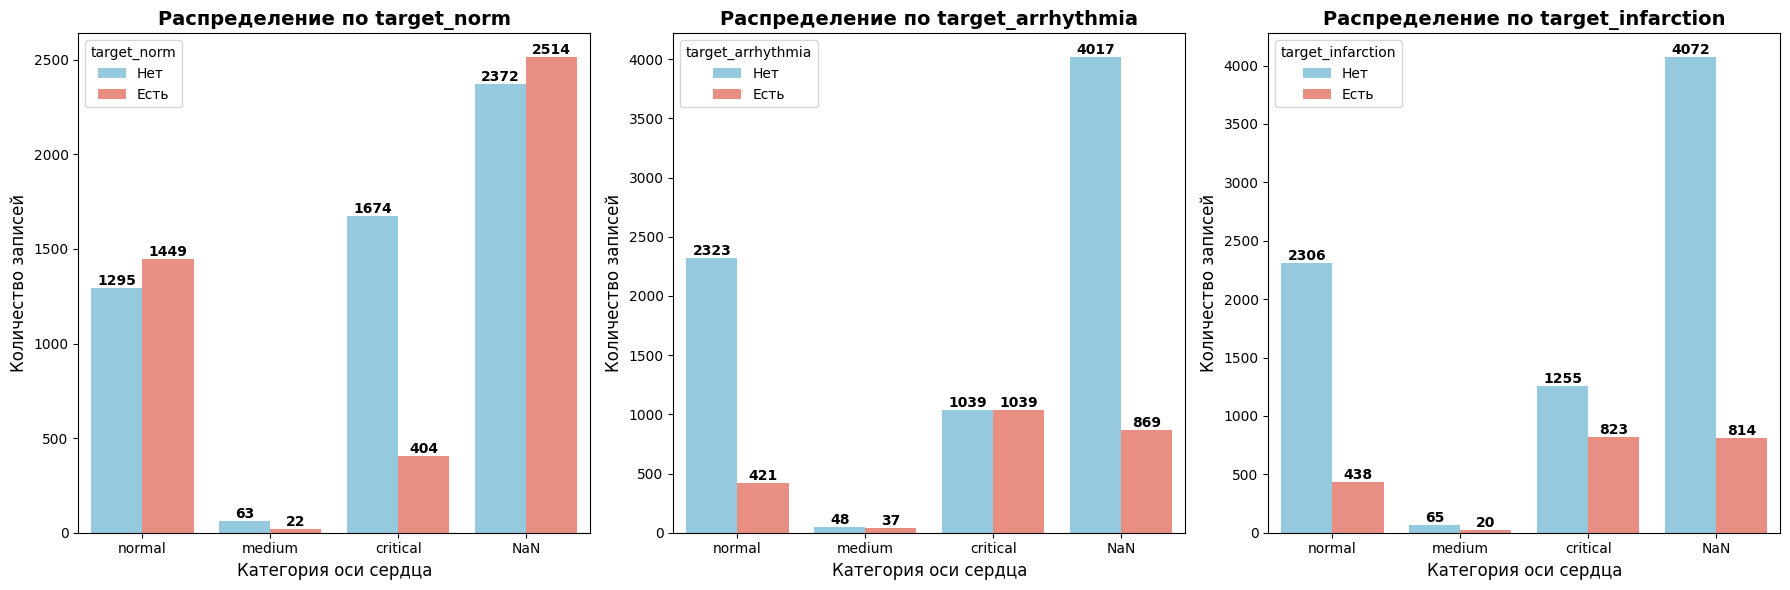

In [122]:
# Версия с seaborn - автоматически обрабатывает NaN
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
target_columns = target_names = ['target_norm', 'target_arrhythmia', 'target_infarction']
for idx, (target_col, target_name) in enumerate(zip(target_columns, target_names)):
    # Создаем временный DataFrame
    plot_data = df[['heart_axis_cat', target_col]].copy()

    # Заменяем NaN на строку 'NaN' для отображения
    plot_data['heart_axis_cat_display'] = plot_data['heart_axis_cat'].fillna('NaN')

    ax = axes[idx]
    sns.countplot(data=plot_data, x='heart_axis_cat_display', hue=target_col, ax=ax,
                 order=['normal', 'medium', 'critical', 'NaN'],
                 palette={0: 'skyblue', 1: 'salmon'})

    ax.set_title(f'Распределение по {target_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Категория оси сердца', fontsize=12)
    ax.set_ylabel('Количество записей', fontsize=12)
    ax.legend(title=f'{target_name}', labels=['Нет', 'Есть'])

    # Добавляем значения на столбцы
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()

Создадим бинарный признак heart_axis_norm: 1 - отсутствие отклонения, 0 - наличие отклоненения.

Данный признак остается единственный категориальным признаком для моделирования

In [123]:
df['heart_axis_norm'] = df['heart_axis_cat'].apply(lambda x: 1 if pd.isna(x) or x in ['normal', 'medium'] else 0)
categorical_columns = ['heart_axis_norm']

Проанализируем булевы переменные

In [124]:
results = analyze_categorical_columns(df, bool_columns )

# Отображение результатов
for col, stats in results.items():
    print(f"\nПризнак: {col}")
    print(f"   Всего записей: {stats['total_count']}")
    print(f"   NaN: {stats['nan_count']} ({stats['nan_percent']:.2f}%)")
    if stats['unique_values']:
        print(f"   Значения: {stats['unique_values']}")
    else:
        print(f"   Значения: []")


Признак: V1_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: V2_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: V3_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: V4_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: V5_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: V6_pathological_Q
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: second_opinion
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: initial_autogenerated_report
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [False, True]

Признак: validated_by_human
   Всего записей: 9793
   NaN: 0 (0.00%)
   Значения: [True, False]


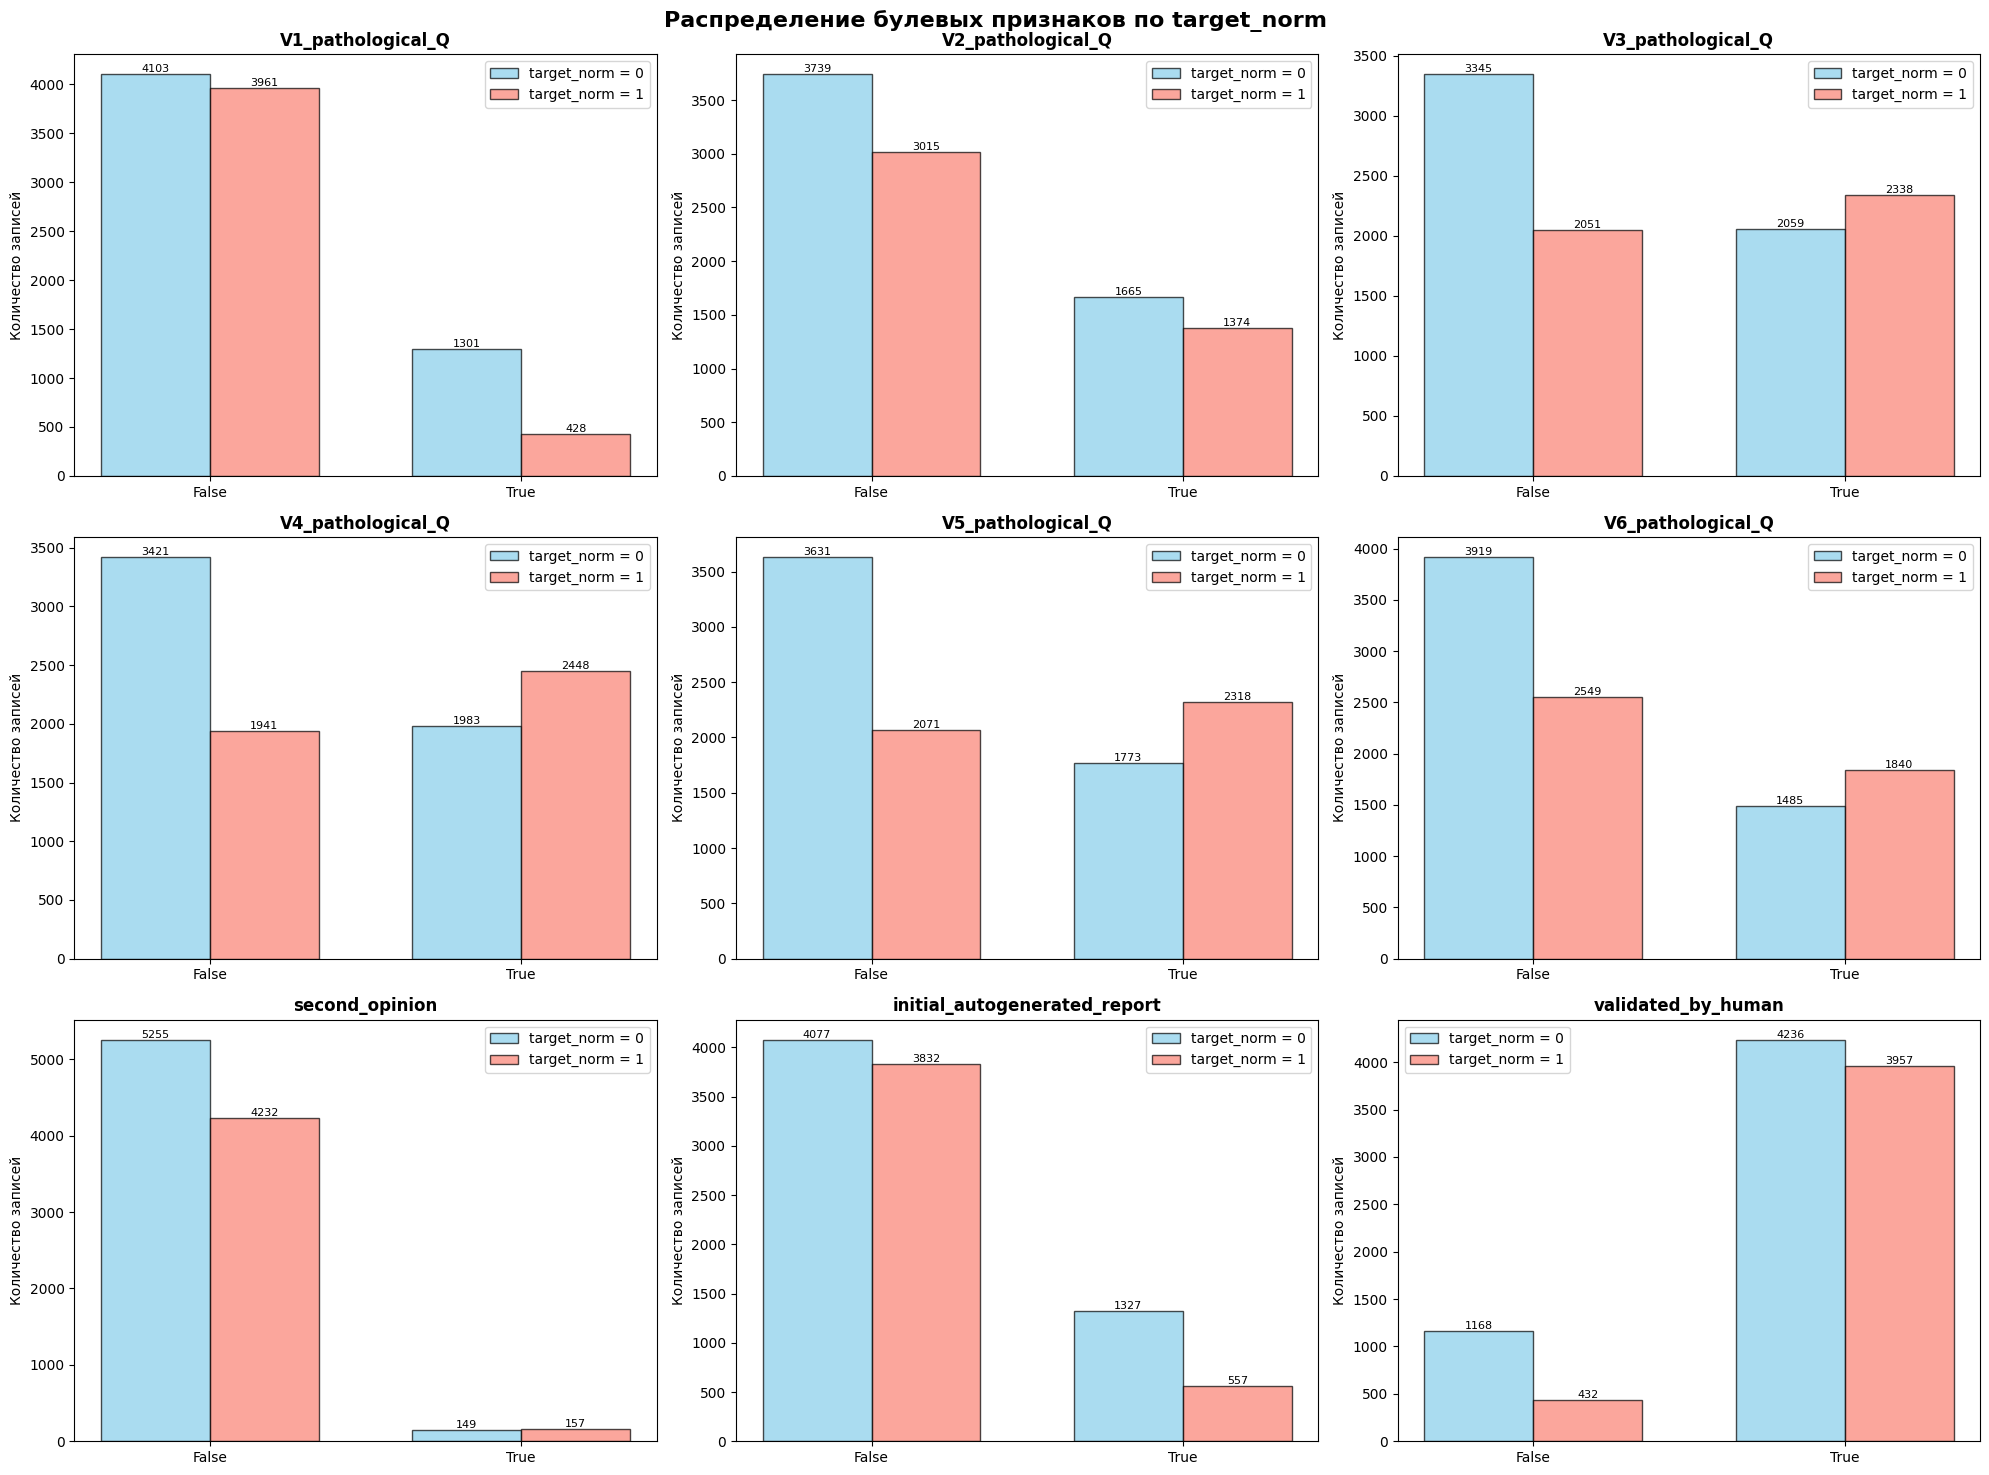

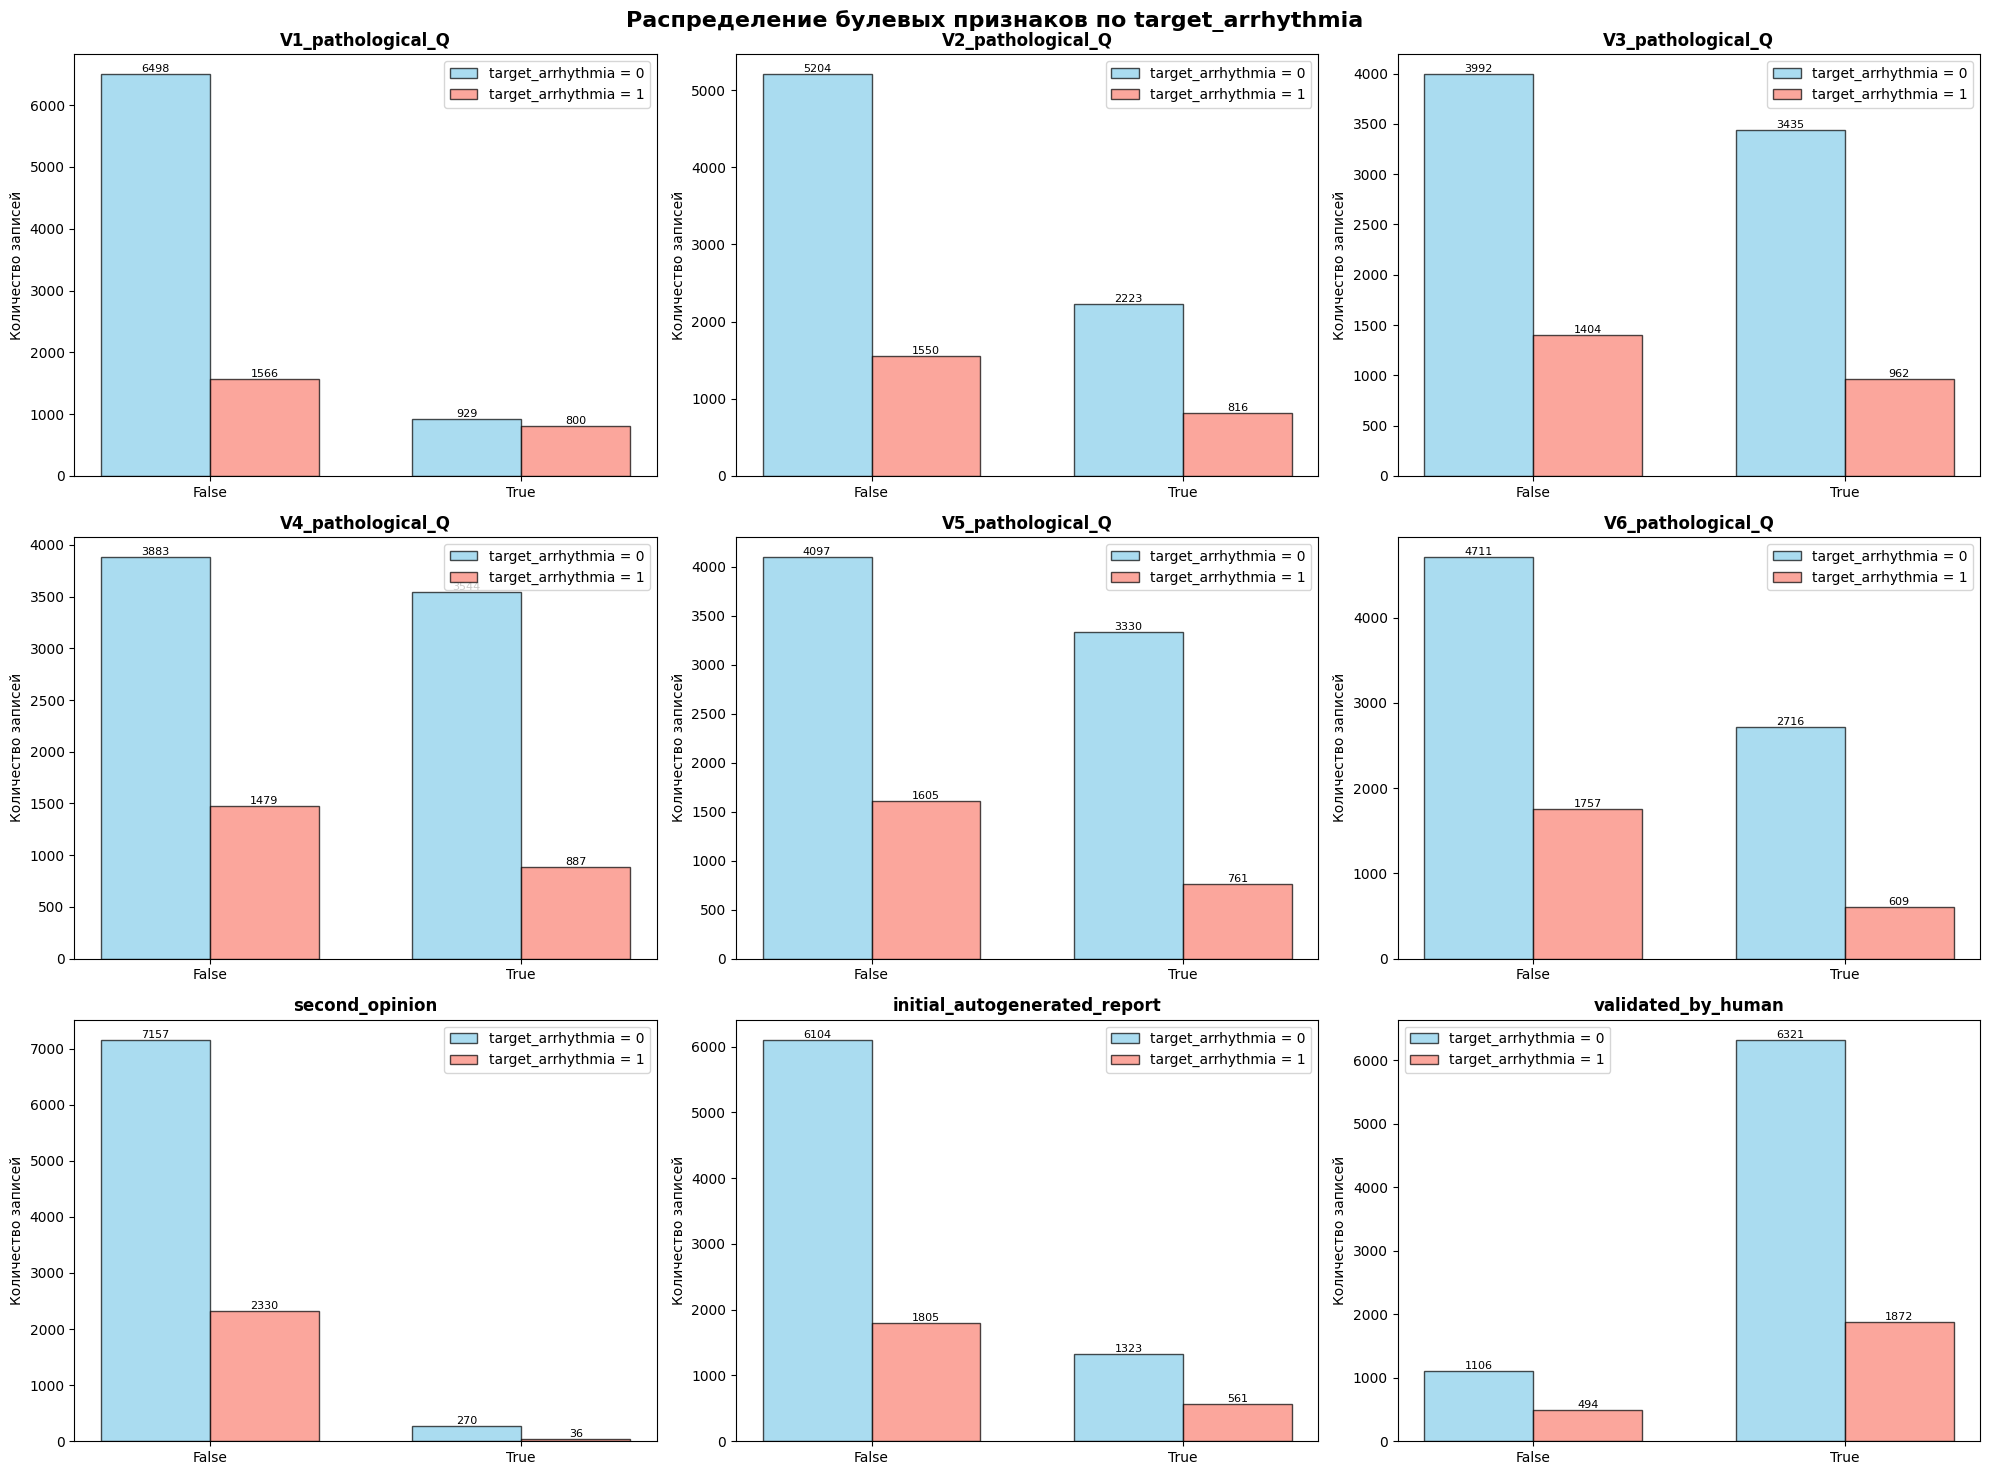

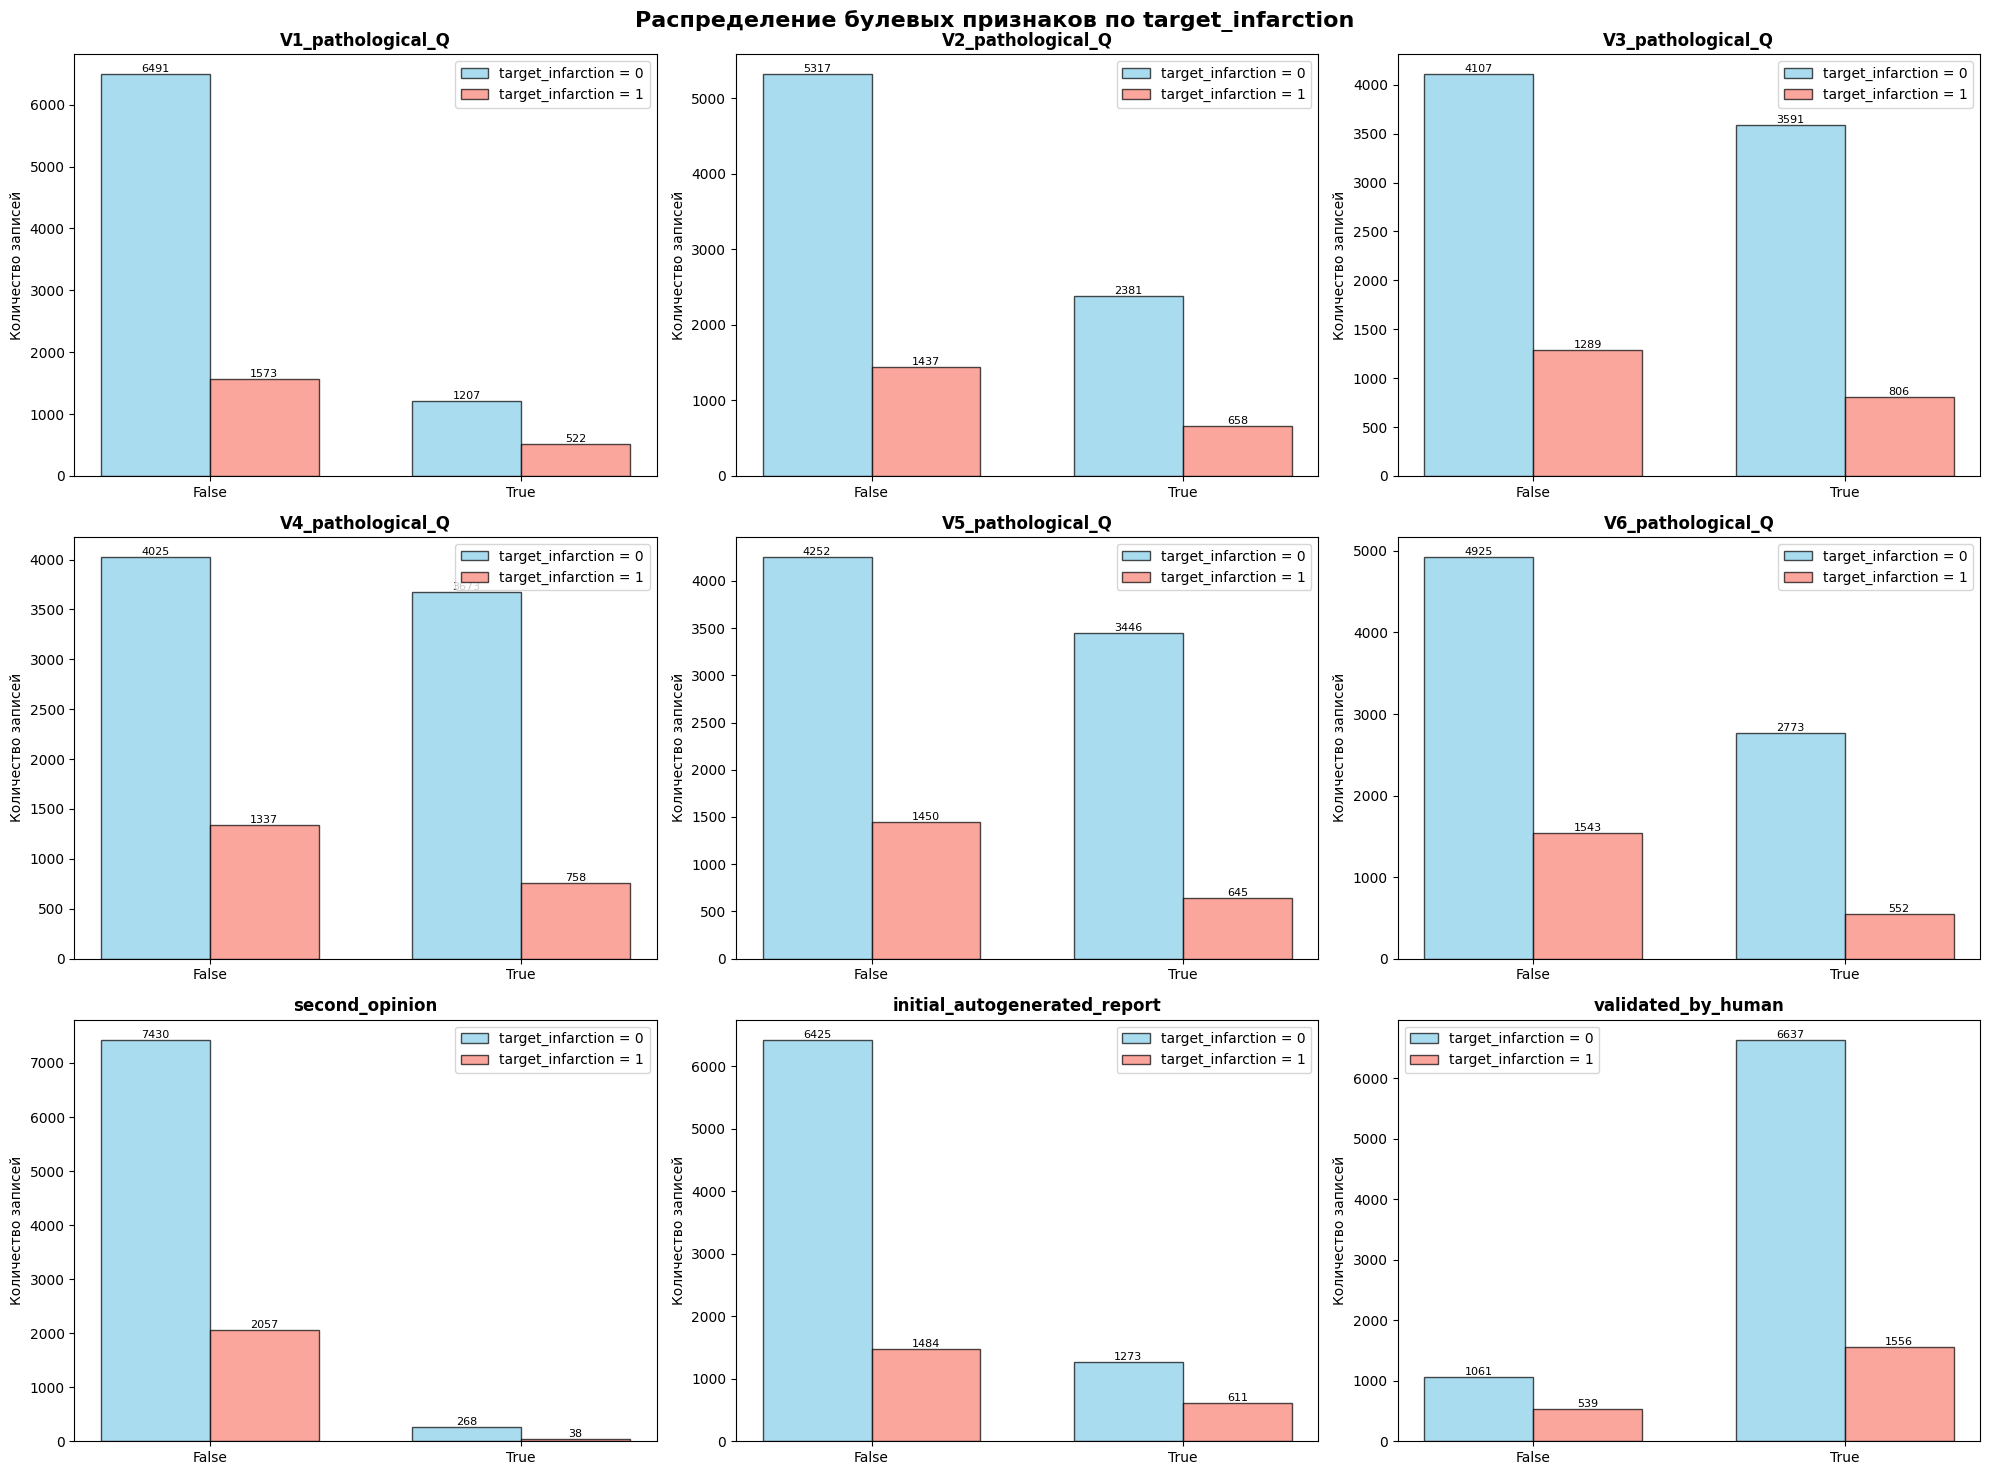

In [125]:
# Построим для каждой целевой переменной отдельно
for target_col, target_name in zip(target_columns, target_names):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    fig.suptitle(f'Распределение булевых признаков по {target_name}', fontsize=16, fontweight='bold')

    for idx, bool_col in enumerate(bool_columns[:9]):
        if idx >= len(axes):
            break

        ax = axes[idx]

        # Данные для текущего признака и целевой переменной
        target_0_data = df[df[target_col] == 0][bool_col]
        target_1_data = df[df[target_col] == 1][bool_col]

        # Подсчет значений
        target_0_counts = [len(target_0_data[~target_0_data]), len(target_0_data[target_0_data])]
        target_1_counts = [len(target_1_data[~target_1_data]), len(target_1_data[target_1_data])]

        # Позиции для столбцов
        x = np.arange(2)
        width = 0.35

        bars1 = ax.bar(x - width/2, target_0_counts, width, label=f'{target_name} = 0',
                      color='skyblue', alpha=0.7, edgecolor='black')
        bars2 = ax.bar(x + width/2, target_1_counts, width, label=f'{target_name} = 1',
                      color='salmon', alpha=0.7, edgecolor='black')

        ax.set_title(bool_col, fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Количество записей', fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(['False', 'True'])
        ax.legend()

        # Добавляем значения
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                           f'{int(height)}', ha='center', va='bottom', fontsize=8)

    # Убираем лишние subplots
    for idx in range(len(bool_columns), 9):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [126]:
from scipy.stats import pointbiserialr

def calculate_pointbiserial_correlations(df, bool_columns, target_columns):
    """Вычисляет point-biserial корреляцию между булевыми и целевыми переменными"""
    results = []

    for bool_col in bool_columns:
        for target_col in target_columns:
            # Удаляем NaN для корректного расчета
            clean_df = df[[bool_col, target_col]].dropna()

            if len(clean_df) > 0:
                corr, p_value = pointbiserialr(clean_df[bool_col].astype(int),
                                             clean_df[target_col])
                results.append({
                    'bool_feature': bool_col,
                    'target': target_col,
                    'correlation': corr,
                    'p_value': p_value,
                    'abs_correlation': abs(corr)
                })

    return pd.DataFrame(results)

# Вычисляем корреляции
corr_df = calculate_pointbiserial_correlations(df, bool_columns,
                                             ['target_infarction', 'target_arrhythmia', 'target_norm'])

# Сортируем по абсолютной корреляции
print("Матрица корреляций:")
top_correlations = corr_df.sort_values('abs_correlation', ascending=False)
print(top_correlations.round(4))

Матрица корреляций:
                    bool_feature             target  correlation  p_value  abs_correlation
1              V1_pathological_Q  target_arrhythmia       0.2392   0.0000           0.2392
14             V5_pathological_Q        target_norm       0.2017   0.0000           0.2017
11             V4_pathological_Q        target_norm       0.1906   0.0000           0.1906
2              V1_pathological_Q        target_norm      -0.1868   0.0000           0.1868
26            validated_by_human        target_norm       0.1583   0.0000           0.1583
17             V6_pathological_Q        target_norm       0.1517   0.0000           0.1517
8              V3_pathological_Q        target_norm       0.1517   0.0000           0.1517
23  initial_autogenerated_report        target_norm      -0.1497   0.0000           0.1497
24            validated_by_human  target_infarction      -0.1325   0.0000           0.1325
21  initial_autogenerated_report  target_infarction       0.1314   0.0

Признаки second_opinion, initial_autogenerated_report, validated_by_human будут удалены так как цель работы - создание модели для интепретации ЭКГ по физическим параметрам исследования.

V1-V6_pathological_Q описывают наличие или отсутствие зубца Q-зубца в грудных отведениях.
V1-V2: Передне-перегородочная область
V3-V4: Передняя стенка
V5-V6: Боковая стенка

V1_pathological_Q является сильнейшим предиктором (высокая корреляция с аритмией).

V2_pathological_Q имеет слабейшую корреляцию

V3-V6 - могут давать ложные Q-зубцы у здоровых людей. Они вносят шум и ухудшают предсказание.

Возможные причины:

Проблемы с разметкой данных:

Ложные срабатывания алгоритма детекции Q-зубцов

Некорректные пороги для "патологичности"

Особенности популяции (возможно, спортивная выборка)

Медицинские особенности:

Нормальные варианты Q-зубцов в боковых отведениях

Позиционные изменения у здоровых людей


**Оставляем единственные булевый признак V1_pathological_Q**

In [127]:
bool_columns = ['V1_pathological_Q']

Проведем анализ количественных переменных

Создадим список numeric_columns для анализа

In [128]:
# Получаем все числовые переменные
numeric_columns = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns.tolist()

print(f"Исходное количество числовых переменных: {len(numeric_columns)}")

# Признаки для исключения по названиям
exclude_patterns = ['target', 'scp']  # исключаем содержащие эти подстроки

# Дополнительные признаки для исключения
exclude_columns = [
    'heart_axis_norm',
    'ecg_id',
    'sex',
    'age',
    'height',
    'weight'
]

# Мета-колонки
meta_columns = [
    'ecg_id', 'patient_id', 'nurse', 'site', 'device', 'recording_date',
    'report', 'filename_lr', 'filename_hr', 'strat_fold', 'validated_by',
    'second_opinion', 'initial_autogenerated_report', 'validated_by_human'
]

# Фильтруем numeric_columns
filtered_numeric_columns = [
    col for col in numeric_columns
    if not any(pattern in col for pattern in exclude_patterns) and
    col not in exclude_columns and
    col not in meta_columns
]
numeric_columns = filtered_numeric_columns

Исходное количество числовых переменных: 440


In [129]:
# Создаем DataFrame для хранения статистики
stats_list = []

for col in numeric_columns:
    # Основная статистика
    unique_count = df[col].nunique()
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    median_val = df[col].median()

    # Проценты
    total_count = len(df[col])
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()

    null_percent = (null_count / total_count) * 100
    zero_percent = (zero_count / total_count) * 100
    null_zero_percent = ((null_count + zero_count) / total_count) * 100

    stats_list.append({
        'variable': col,
        'unique_count': unique_count,
        'min': min_val,
        'max': max_val,
        'mean': mean_val,
        'median': median_val,
        'null_count': null_count,
        'null_percent': null_percent,
        'zero_count': zero_count,
        'zero_percent': zero_percent,
        'null_zero_percent': null_zero_percent
    })

# Создаем DataFrame со статистикой
stats_df = pd.DataFrame(stats_list)

# Выводим результат
print("Статистика по количественным переменным:")
stats_df

Статистика по количественным переменным:


,variable,unique_count,min,max,mean,median,null_count,null_percent,zero_count,zero_percent,null_zero_percent
0,I_meanRR,1614,343.333333,2303.333333,842.116711,840.000000,0,0.000000,0,0.000000,0.000000
1,I_sdNN,5345,0.000000,1606.605116,54.609631,23.779288,0,0.000000,11,0.112325,0.112325
2,I_RMSSD,3695,0.000000,2219.622716,69.279715,23.664319,0,0.000000,11,0.112325,0.112325
3,I_pNN50,137,0.000000,94.444444,15.776995,0.000000,0,0.000000,5689,58.092515,58.092515
4,I_LF,0,NaN,NaN,NaN,NaN,9793,100.000000,0,0.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
418,V5_QR_ratio,0,NaN,NaN,NaN,NaN,9793,100.000000,0,0.000000,100.000000
419,V6_QRS_dur,6,105.000000,490.000000,258.333333,225.000000,9787,99.938732,0,0.000000,99.938732
420,V6_QT_int,0,NaN,NaN,NaN,NaN,9793,100.000000,0,0.000000,100.000000
421,V6_PR_int,0,NaN,NaN,NaN,NaN,9793,100.000000,0,0.000000,100.000000


In [130]:
# Фильтруем строки где unique_count < 2
low_unique_stats = stats_df[stats_df['unique_count'] < 2]

print(f"Найдено переменных с unique_count < 2: {len(low_unique_stats)}")
print("=" * 100)

if len(low_unique_stats) > 0:
    print("Переменные для удаления:")
    print(low_unique_stats[['variable', 'unique_count']])

    # Удаляем из stats_df
    stats_df = stats_df[stats_df['unique_count'] >= 2]

    print(f"\nПосле удаления осталось переменных: {len(stats_df)}")
    print("Обновленная stats_df:")
    print(stats_df)
else:
    print("Нет переменных с unique_count < 2")

Найдено переменных с unique_count < 2: 131
Переменные для удаления:
         variable  unique_count
4            I_LF             0
5            I_HF             0
6         I_LF_HF             0
7         I_R_amp             0
13   I_ST_segment             0
..            ...           ...
417     V5_PR_int             0
418   V5_QR_ratio             0
420     V6_QT_int             0
421     V6_PR_int             0
422   V6_QR_ratio             0

[131 rows x 2 columns]

После удаления осталось переменных: 292
Обновленная stats_df:
       variable  unique_count         min          max        mean      median  null_count  null_percent  zero_count  zero_percent  null_zero_percent
0      I_meanRR          1614  343.333333  2303.333333  842.116711  840.000000           0      0.000000           0      0.000000           0.000000
1        I_sdNN          5345    0.000000  1606.605116   54.609631   23.779288           0      0.000000          11      0.112325           0.112325
2       I_R

In [131]:
# Создаем numeric_columns из stats_df['variable']
numeric_columns = stats_df['variable'].tolist()

print(f"Создан numeric_columns с {len(numeric_columns)} переменными:")
print(numeric_columns)

Создан numeric_columns с 292 переменными:
['I_meanRR', 'I_sdNN', 'I_RMSSD', 'I_pNN50', 'I_P_amp', 'I_Q_amp', 'I_S_amp', 'I_T_amp', 'I_PT_ratio', 'I_PSD_mean_freq', 'I_PSD_std_freq', 'I_STFT_energy', 'I_PSD_power_mean', 'I_PSD_power_max', 'I_wavelet_E1', 'I_wavelet_E2', 'I_wavelet_E3', 'I_wavelet_E4', 'I_wavelet_E5', 'I_wavelet_entropy', 'I_SNR_dB', 'I_prop_censored', 'II_meanRR', 'II_sdNN', 'II_RMSSD', 'II_pNN50', 'II_R_amp', 'II_P_amp', 'II_Q_amp', 'II_S_amp', 'II_T_amp', 'II_PT_ratio', 'II_PSD_mean_freq', 'II_PSD_std_freq', 'II_STFT_energy', 'II_PSD_power_mean', 'II_PSD_power_max', 'II_wavelet_E1', 'II_wavelet_E2', 'II_wavelet_E3', 'II_wavelet_E4', 'II_wavelet_E5', 'II_wavelet_entropy', 'II_SNR_dB', 'II_prop_censored', 'III_meanRR', 'III_sdNN', 'III_RMSSD', 'III_pNN50', 'III_R_amp', 'III_P_amp', 'III_Q_amp', 'III_S_amp', 'III_T_amp', 'III_PT_ratio', 'III_PSD_mean_freq', 'III_PSD_std_freq', 'III_STFT_energy', 'III_PSD_power_mean', 'III_PSD_power_max', 'III_wavelet_E1', 'III_wavelet_E2

Заменим 0.0 на NaN

In [132]:
# Признаки, где 0.0 считаем ВАЛИДНЫМ (не трогаем)
valid_zero_features = [
    'prop_censored',  # может быть 0 - идеальный сигнал
    'PT_ratio',       # теоретически может быть 0
    'Q_wave_amp',     # может быть 0 - отсутствие патологического Q
    'Q_wave_dur',     # может быть 0 - отсутствие патологического Q
]

# Колонки для обработки (исключая valid_zero_features)
columns_to_process = [col for col in numeric_columns if col not in valid_zero_features]

print(f"Всего numeric_columns: {len(numeric_columns)}")
print(f"Будет обработано: {len(columns_to_process)}")
print(f"Исключено (valid zeros): {len(numeric_columns) - len(columns_to_process)}")

# Заменяем 0 на NaN в выбранных колонках
for col in columns_to_process:
    zero_count_before = (df[col] == 0).sum()
    df[col] = df[col].replace(0, np.nan)
    zero_count_after = (df[col] == 0).sum()

    print(f"{col}: заменено {zero_count_before - zero_count_after} нулей на NaN")

print("Замена завершена")

Всего numeric_columns: 292
Будет обработано: 292
Исключено (valid zeros): 0
I_meanRR: заменено 0 нулей на NaN
I_sdNN: заменено 11 нулей на NaN
I_RMSSD: заменено 11 нулей на NaN
I_pNN50: заменено 5689 нулей на NaN
I_P_amp: заменено 0 нулей на NaN
I_Q_amp: заменено 0 нулей на NaN
I_S_amp: заменено 0 нулей на NaN
I_T_amp: заменено 0 нулей на NaN
I_PT_ratio: заменено 0 нулей на NaN
I_PSD_mean_freq: заменено 0 нулей на NaN
I_PSD_std_freq: заменено 0 нулей на NaN
I_STFT_energy: заменено 0 нулей на NaN
I_PSD_power_mean: заменено 0 нулей на NaN
I_PSD_power_max: заменено 0 нулей на NaN
I_wavelet_E1: заменено 0 нулей на NaN
I_wavelet_E2: заменено 0 нулей на NaN
I_wavelet_E3: заменено 0 нулей на NaN
I_wavelet_E4: заменено 0 нулей на NaN
I_wavelet_E5: заменено 0 нулей на NaN
I_wavelet_entropy: заменено 0 нулей на NaN
I_SNR_dB: заменено 0 нулей на NaN
I_prop_censored: заменено 1908 нулей на NaN
II_meanRR: заменено 0 нулей на NaN
II_sdNN: заменено 10 нулей на NaN
II_RMSSD: заменено 10 нулей на NaN
I

Обновляем статистику

In [133]:
stats_list = []

for col in numeric_columns:
    # Основная статистика
    unique_count = df[col].nunique()
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    median_val = df[col].median()

    # Проценты
    total_count = len(df[col])
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()

    null_percent = (null_count / total_count) * 100
    zero_percent = (zero_count / total_count) * 100
    null_zero_percent = ((null_count + zero_count) / total_count) * 100

    stats_list.append({
        'variable': col,
        'unique_count': unique_count,
        'min': min_val,
        'max': max_val,
        'mean': mean_val,
        'median': median_val,
        'null_count': null_count,
        'null_percent': null_percent,
        'zero_count': zero_count,
        'zero_percent': zero_percent,
        'null_zero_percent': null_zero_percent
    })

# Создаем DataFrame со статистикой
stats_df = pd.DataFrame(stats_list)

# Выводим результат
print("Статистика по количественным переменным:")
stats_df

Статистика по количественным переменным:


,variable,unique_count,min,max,mean,median,null_count,null_percent,zero_count,zero_percent,null_zero_percent
0,I_meanRR,1614,343.333333,2303.333333,842.116711,840.000000,0,0.000000,0,0.0,0.000000
1,I_sdNN,5344,2.357023,1606.605116,54.671041,23.836557,11,0.112325,0,0.0,0.112325
2,I_RMSSD,3694,2.773501,2219.622716,69.357621,23.717082,11,0.112325,0,0.0,0.112325
3,I_pNN50,136,3.846154,94.444444,37.647200,33.333333,5689,58.092515,0,0.0,58.092515
4,I_P_amp,6446,-0.064155,0.229182,0.025528,0.023587,3347,34.177474,0,0.0,34.177474
...,...,...,...,...,...,...,...,...,...,...,...
287,V1_QRS_dur,63,70.000000,486.666667,170.472222,140.000000,9673,98.774635,0,0.0,98.774635
288,V2_QRS_dur,33,70.000000,490.000000,167.134503,110.000000,9736,99.417952,0,0.0,99.417952
289,V3_QRS_dur,35,75.000000,490.000000,189.518519,130.000000,9748,99.540488,0,0.0,99.540488
290,V5_QRS_dur,6,130.000000,315.000000,197.222222,182.500000,9787,99.938732,0,0.0,99.938732


Удаляем признаки с больше 10 процентов пропусков

In [134]:
percent_filter = 10
# Фильтруем признаки с null_percent > percent_filter
high_null_mask = stats_df['null_percent'] > percent_filter
high_null_stats = stats_df[high_null_mask]

print(f"Найдено переменных с null_percent > {percent_filter}: {len(high_null_stats)}")

if len(high_null_stats) > 0:
    print("Переменные для удаления:")
    for _, row in high_null_stats.iterrows():
        print(f"  - {row['variable']}: null_percent = {row['null_percent']:.1f}%")

    # Сохраняем список удаленных переменных
    removed_variables = high_null_stats['variable'].tolist()

    # Удаляем из stats_df
    stats_df = stats_df[~high_null_mask]

    # Удаляем из numeric_columns
    numeric_columns = [col for col in numeric_columns if col not in removed_variables]

    print(f"\nРЕЗУЛЬТАТ УДАЛЕНИЯ:")
    print(f"  Удалено переменных: {len(removed_variables)}")
    print(f"  Осталось в stats_df: {len(stats_df)}")
    print(f"  Осталось в numeric_columns: {len(numeric_columns)}")

else:
    print(f"Нет переменных с null_percent > {percent_filter}")

Найдено переменных с null_percent > 10: 108
Переменные для удаления:
  - I_pNN50: null_percent = 58.1%
  - I_P_amp: null_percent = 34.2%
  - I_Q_amp: null_percent = 34.2%
  - I_S_amp: null_percent = 34.2%
  - I_T_amp: null_percent = 34.2%
  - I_PT_ratio: null_percent = 34.2%
  - I_prop_censored: null_percent = 19.5%
  - II_pNN50: null_percent = 56.4%
  - II_R_amp: null_percent = 99.9%
  - II_P_amp: null_percent = 40.4%
  - II_Q_amp: null_percent = 40.4%
  - II_S_amp: null_percent = 40.4%
  - II_T_amp: null_percent = 40.4%
  - II_PT_ratio: null_percent = 40.4%
  - II_prop_censored: null_percent = 29.3%
  - III_pNN50: null_percent = 43.7%
  - III_R_amp: null_percent = 99.4%
  - III_P_amp: null_percent = 49.4%
  - III_Q_amp: null_percent = 49.4%
  - III_S_amp: null_percent = 49.4%
  - III_T_amp: null_percent = 49.4%
  - III_PT_ratio: null_percent = 49.4%
  - III_prop_censored: null_percent = 29.5%
  - AVR_pNN50: null_percent = 31.2%
  - AVR_R_amp: null_percent = 98.8%
  - AVR_P_amp: null_

In [135]:
# Выводим результат
print("Статистика по количественным переменным:")
stats_df

Статистика по количественным переменным:


,variable,unique_count,min,max,mean,median,null_count,null_percent,zero_count,zero_percent,null_zero_percent
0,I_meanRR,1614,343.333333,2303.333333,842.116711,840.000000,0,0.000000,0,0.0,0.000000
1,I_sdNN,5344,2.357023,1606.605116,54.671041,23.836557,11,0.112325,0,0.0,0.112325
2,I_RMSSD,3694,2.773501,2219.622716,69.357621,23.717082,11,0.112325,0,0.0,0.112325
9,I_PSD_mean_freq,9793,0.874883,19.652003,9.270232,9.342459,0,0.000000,0,0.0,0.000000
10,I_PSD_std_freq,9793,1.983393,13.764406,7.090516,7.145218,0,0.000000,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
275,V6_wavelet_E4,9793,0.120520,145.461267,8.736126,6.326452,0,0.000000,0,0.0,0.000000
276,V6_wavelet_E5,9793,0.019429,51.892114,2.154102,1.472153,0,0.000000,0,0.0,0.000000
277,V6_wavelet_entropy,9793,1.206243,6.526798,5.445571,5.630182,0,0.000000,0,0.0,0.000000
278,V6_SNR_dB,9793,0.036615,70.544769,23.361158,22.716602,0,0.000000,0,0.0,0.000000


Заменим пропущенные значения в numeric_columns на медиану

In [136]:
for col in numeric_columns:
    # Считаем пропуски до замены
    null_count_before = df[col].isnull().sum()

    if null_count_before > 0:
        # Вычисляем медиану (игнорируя NaN)
        median_value = df[col].median()

        # Заменяем NaN на медиану
        df[col].fillna(median_value, inplace=True)

        # Считаем пропуски после замены
        null_count_after = df[col].isnull().sum()

        print(f"{col}: заменено {null_count_before} пропусков на медиану {median_value:.4f}")


I_sdNN: заменено 11 пропусков на медиану 23.8366
I_RMSSD: заменено 11 пропусков на медиану 23.7171
II_meanRR: заменено 4 пропусков на медиану 840.0000
II_sdNN: заменено 14 пропусков на медиану 25.0000
II_RMSSD: заменено 14 пропусков на медиану 24.8998
III_meanRR: заменено 37 пропусков на медиану 841.0000
III_sdNN: заменено 44 пропусков на медиану 34.1402
III_RMSSD: заменено 44 пропусков на медиану 37.8994
AVR_meanRR: заменено 33 пропусков на медиану 851.0000
AVR_sdNN: заменено 41 пропусков на медиану 43.6238
AVR_RMSSD: заменено 41 пропусков на медиану 58.7367
AVL_meanRR: заменено 4 пропусков на медиану 840.0000
AVL_sdNN: заменено 11 пропусков на медиану 25.9604
AVL_RMSSD: заменено 11 пропусков на медиану 26.1529
AVF_meanRR: заменено 16 пропусков на медиану 841.0000
AVF_sdNN: заменено 27 пропусков на медиану 28.2843
AVF_RMSSD: заменено 27 пропусков на медиану 29.4392
V1_meanRR: заменено 39 пропусков на медиану 847.0000
V1_sdNN: заменено 42 пропусков на медиану 28.2056
V1_RMSSD: заменено

/tmp/ipython-input-3333381322.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


Проанализируем рост, вес, возраст

In [137]:
# Создаем список с переменными
demographic_columns = ['age', 'weight', 'height']

print("ПЕРЕМЕННЫЕ ДЕМОГРАФИИ:")
print(demographic_columns)
print()

# Проверяем существование колонок в DataFrame
existing_columns = [col for col in demographic_columns if col in df.columns]
missing_columns = [col for col in demographic_columns if col not in df.columns]

print(f"Найдено в DataFrame: {existing_columns}")
if missing_columns:
    print(f"Отсутствуют в DataFrame: {missing_columns}")

ПЕРЕМЕННЫЕ ДЕМОГРАФИИ:
['age', 'weight', 'height']

Найдено в DataFrame: ['age', 'weight', 'height']


Согласно описанию датасета для пациентов возрастом более 89 был установлен возраст 300 лет для конфидициальности

In [138]:
demographic_columns = ['age', 'weight', 'height']
count_before = (df['age'] > 90).sum()
df.loc[df['age'] > 90, 'age'] = 90
for col in demographic_columns:
    if col in df.columns:
        total_count = len(df[col])
        null_count = df[col].isnull().sum()
        null_percent = (null_count / total_count) * 100

        print(f"{col}:")
        print(f"  Всего записей: {total_count}")
        print(f"  Пропусков: {null_count} ({null_percent:.1f}%)")

        # Базовая статистика если есть данные
        if null_count < total_count:
            print(f"  Мин: {df[col].min()}")
            print(f"  Макс: {df[col].max()}")
            print(f"  Среднее: {df[col].mean():.1f}")
            print(f"  Медиана: {df[col].median():.1f}")
    print()

age:
  Всего записей: 9793
  Пропусков: 0 (0.0%)
  Мин: 3.0
  Макс: 90.0
  Среднее: 59.5
  Медиана: 61.0

weight:
  Всего записей: 9793
  Пропусков: 4401 (44.9%)
  Мин: 5.0
  Макс: 210.0
  Среднее: 70.8
  Медиана: 70.0

height:
  Всего записей: 9793
  Пропусков: 5919 (60.4%)
  Мин: 6.0
  Макс: 197.0
  Среднее: 166.6
  Медиана: 165.0



/tmp/ipython-input-3601246358.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i, j].boxplot(data_to_plot, labels=labels)
/tmp/ipython-input-3601246358.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i, j].boxplot(data_to_plot, labels=labels)
/tmp/ipython-input-3601246358.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i, j].boxplot(data_to_plot, labels=labels)
/tmp/ipython-input-3601246358.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i, j].boxplot(data_

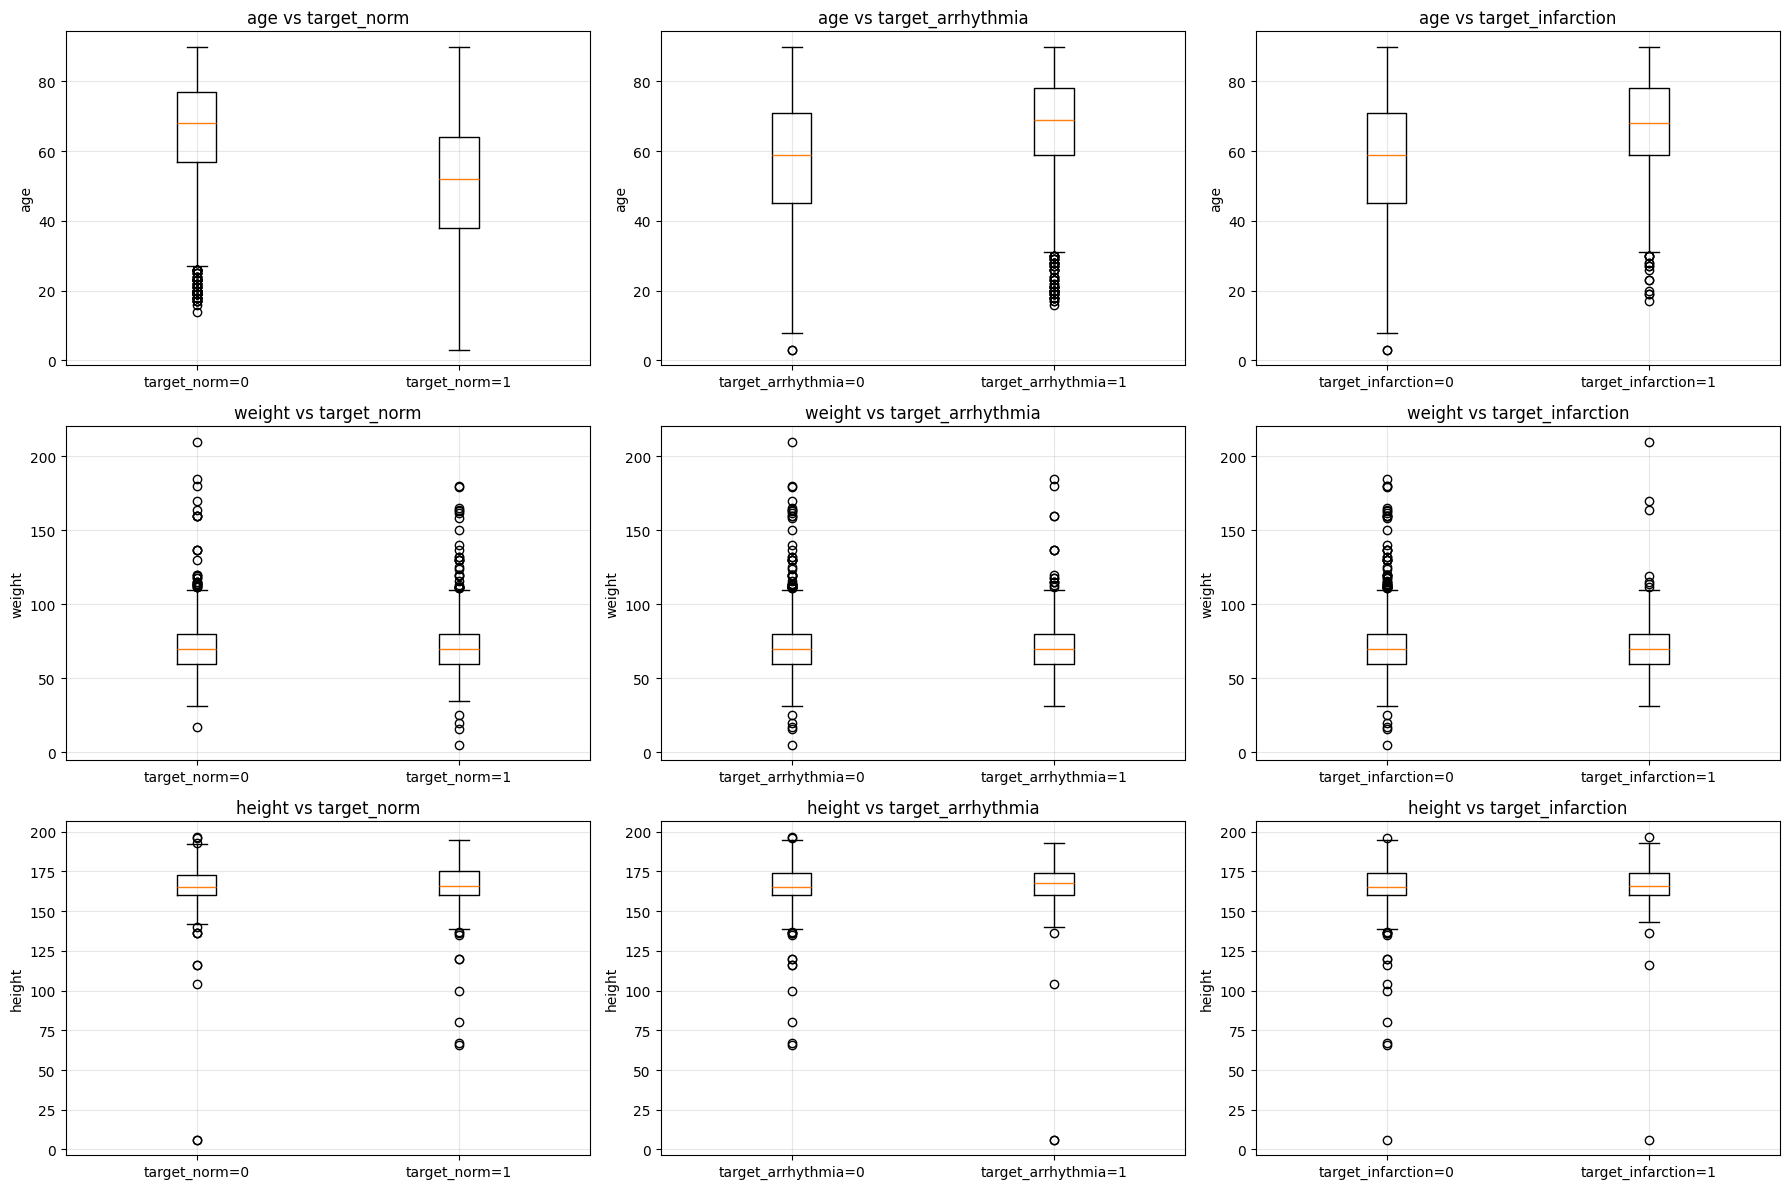

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем фигуру с несколькими subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Список демографических переменных
demo_columns = ['age', 'weight', 'height']
target_columns = ['target_norm', 'target_arrhythmia', 'target_infarction']

# Строим боксплоты для каждой комбинации
for i, demo_col in enumerate(demo_columns):
    for j, target_col in enumerate(target_columns):
        if demo_col in df.columns and target_col in df.columns:
            # Создаем данные для боксплота
            data_to_plot = []
            labels = []

            for target_val in [0, 1]:
                subset = df[df[target_col] == target_val][demo_col].dropna()
                if len(subset) > 0:
                    data_to_plot.append(subset)
                    labels.append(f'{target_col}={target_val}')

            if len(data_to_plot) > 0:
                axes[i, j].boxplot(data_to_plot, labels=labels)
                axes[i, j].set_title(f'{demo_col} vs {target_col}')
                axes[i, j].set_ylabel(demo_col)
                axes[i, j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

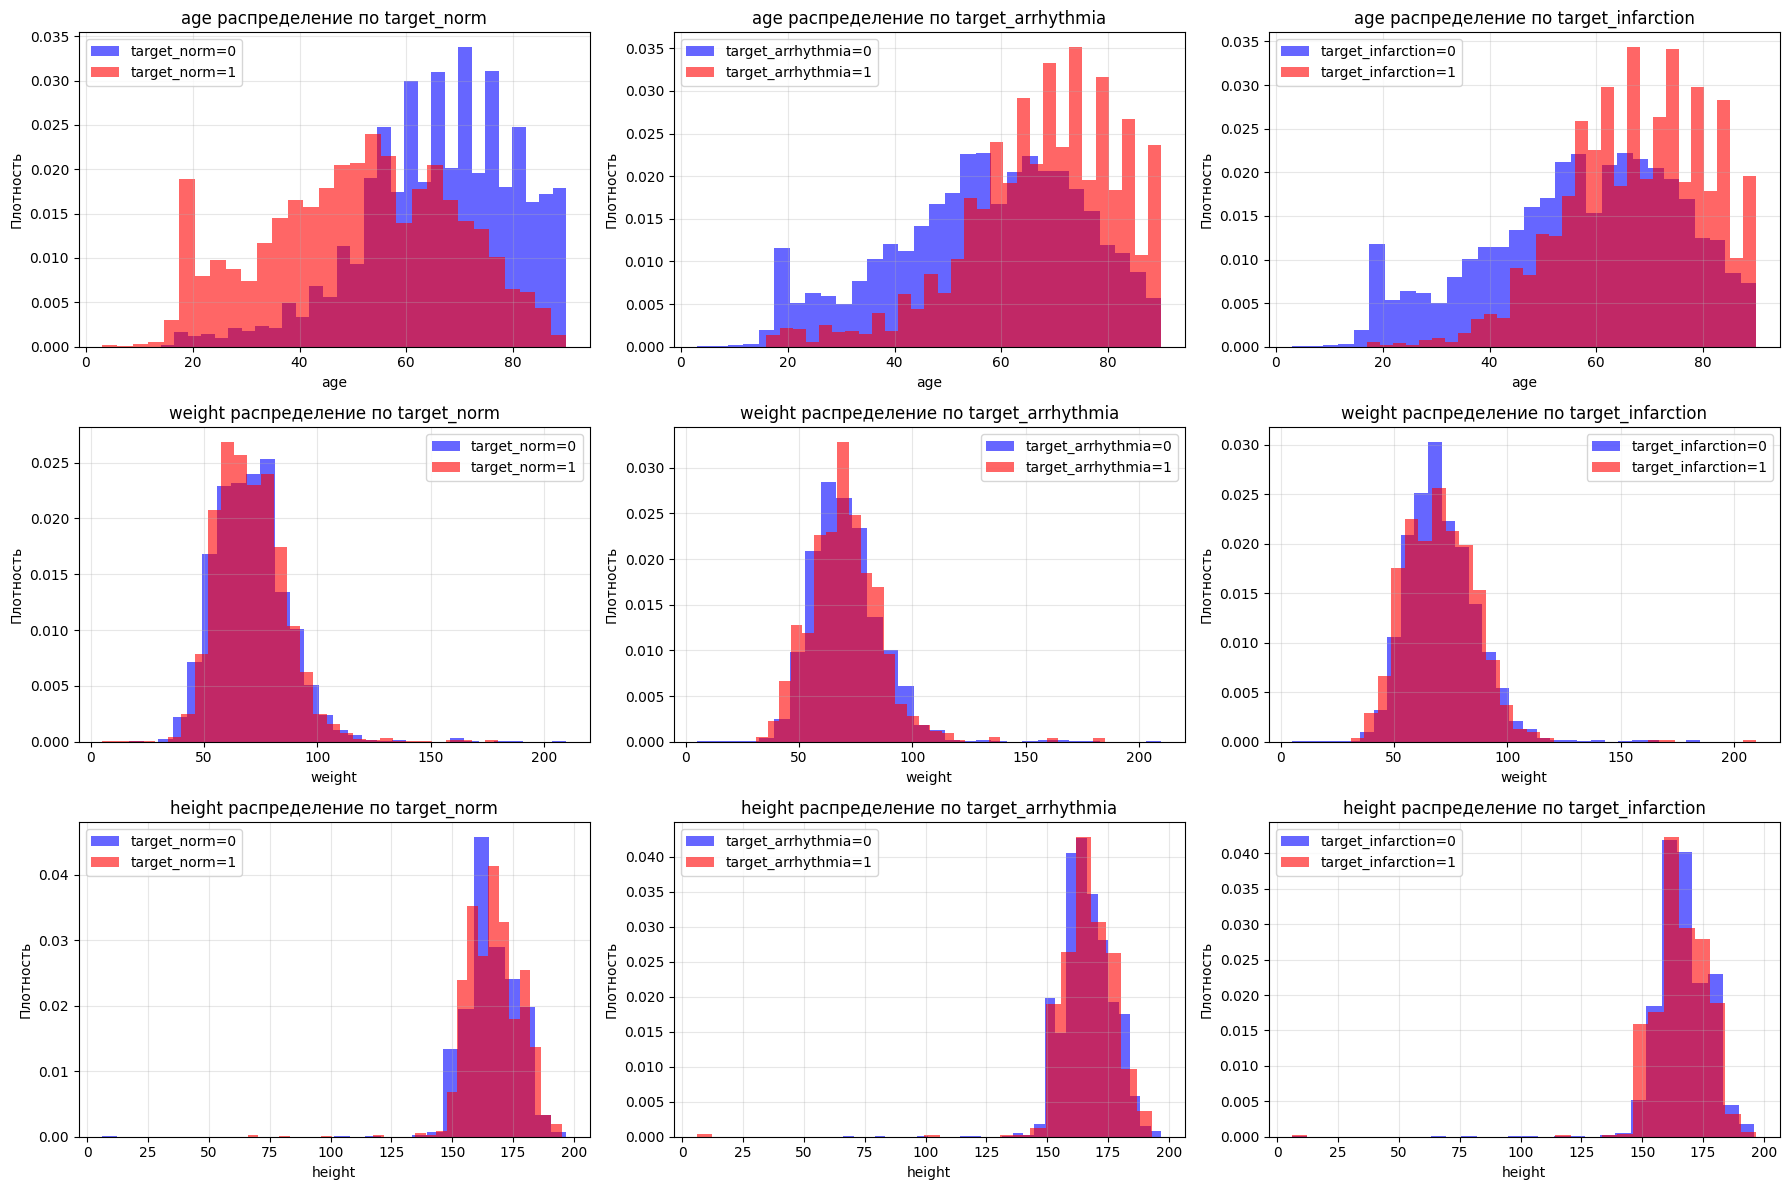

In [140]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, demo_col in enumerate(demo_columns):
    for j, target_col in enumerate(target_columns):
        if demo_col in df.columns and target_col in df.columns:
            # Разделяем данные по значениям целевой переменной
            data_0 = df[df[target_col] == 0][demo_col].dropna()
            data_1 = df[df[target_col] == 1][demo_col].dropna()

            if len(data_0) > 0 and len(data_1) > 0:
                # Строим гистограммы с наложением
                axes[i, j].hist(data_0, bins=30, alpha=0.6, label=f'{target_col}=0',
                               color='blue', density=True)
                axes[i, j].hist(data_1, bins=30, alpha=0.6, label=f'{target_col}=1',
                               color='red', density=True)

                axes[i, j].set_title(f'{demo_col} распределение по {target_col}')
                axes[i, j].set_xlabel(demo_col)
                axes[i, j].set_ylabel('Плотность')
                axes[i, j].legend()
                axes[i, j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Оставляем только признак age

In [141]:
demographic_columns = ['age']

Далее признаки, которые потенциально можно взять в ML.

Необходимо избавиться от мультиколинеарности в numeric_columns. А также обработать выбросы

In [142]:
print("Для дальнейшего анализа имеем")
print('Категориальные признаки')
print(categorical_columns)
print('Булевые признаки')
print(bool_columns)
print('Демографические признаки')
print(demographic_columns)
print('Количественные признаки признаки')
print(numeric_columns)

Для дальнейшего анализа имеем
Категориальные признаки
['heart_axis_norm']
Булевые признаки
['V1_pathological_Q']
Демографические признаки
['age']
Количественные признаки признаки
['I_meanRR', 'I_sdNN', 'I_RMSSD', 'I_PSD_mean_freq', 'I_PSD_std_freq', 'I_STFT_energy', 'I_PSD_power_mean', 'I_PSD_power_max', 'I_wavelet_E1', 'I_wavelet_E2', 'I_wavelet_E3', 'I_wavelet_E4', 'I_wavelet_E5', 'I_wavelet_entropy', 'I_SNR_dB', 'II_meanRR', 'II_sdNN', 'II_RMSSD', 'II_PSD_mean_freq', 'II_PSD_std_freq', 'II_STFT_energy', 'II_PSD_power_mean', 'II_PSD_power_max', 'II_wavelet_E1', 'II_wavelet_E2', 'II_wavelet_E3', 'II_wavelet_E4', 'II_wavelet_E5', 'II_wavelet_entropy', 'II_SNR_dB', 'III_meanRR', 'III_sdNN', 'III_RMSSD', 'III_PSD_mean_freq', 'III_PSD_std_freq', 'III_STFT_energy', 'III_PSD_power_mean', 'III_PSD_power_max', 'III_wavelet_E1', 'III_wavelet_E2', 'III_wavelet_E3', 'III_wavelet_E4', 'III_wavelet_E5', 'III_wavelet_entropy', 'III_SNR_dB', 'AVR_meanRR', 'AVR_sdNN', 'AVR_RMSSD', 'AVR_PSD_mean_freq'

Оцениваем наличие корреляций между признаками

In [143]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def analyze_correlations(df, feature_list, r=0.7):
    """
    Анализирует корреляции между признаками в списке
    """

    # Проверяем что признаки существуют в DataFrame
    existing_features = [col for col in feature_list if col in df.columns]
    missing_features = [col for col in feature_list if col not in df.columns]

    if missing_features:
        print(f"Предупреждение: следующие признаки отсутствуют в DataFrame: {missing_features}")

    if len(existing_features) == 0:
        print("Нет признаков для анализа")
        return pd.DataFrame(), []

    # Вычисляем матрицу корреляций
    correlation_matrix = df[existing_features].corr()

    print(f"Размер матрицы: {correlation_matrix.shape}")
    print("\nМатрица корреляций:")
    print(correlation_matrix.round(3))

    # Находим высокие корреляции
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > r:
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))

    print(f"\nВысокие корреляции (|r| > {r}): {len(high_corr_pairs)}")
    if high_corr_pairs:
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} - {var2}: {corr:.3f}")
    else:
        print("  Высоких корреляций не найдено")

In [144]:
analyze_correlations (df, numeric_columns)

Размер матрицы: (184, 184)

Матрица корреляций:
                    I_meanRR  I_sdNN  I_RMSSD  I_PSD_mean_freq  I_PSD_std_freq  I_STFT_energy  I_PSD_power_mean  I_PSD_power_max  I_wavelet_E1  I_wavelet_E2  I_wavelet_E3  I_wavelet_E4  I_wavelet_E5  I_wavelet_entropy  I_SNR_dB  II_meanRR  II_sdNN  II_RMSSD  II_PSD_mean_freq  II_PSD_std_freq  II_STFT_energy  II_PSD_power_mean  II_PSD_power_max  II_wavelet_E1  II_wavelet_E2  II_wavelet_E3  II_wavelet_E4  II_wavelet_E5  II_wavelet_entropy  II_SNR_dB  III_meanRR  III_sdNN  III_RMSSD  III_PSD_mean_freq  III_PSD_std_freq  III_STFT_energy  III_PSD_power_mean  III_PSD_power_max  III_wavelet_E1  III_wavelet_E2  III_wavelet_E3  III_wavelet_E4  III_wavelet_E5  III_wavelet_entropy  III_SNR_dB  AVR_meanRR  AVR_sdNN  AVR_RMSSD  AVR_PSD_mean_freq  AVR_PSD_std_freq  AVR_STFT_energy  AVR_PSD_power_mean  AVR_PSD_power_max  AVR_wavelet_E1  AVR_wavelet_E2  AVR_wavelet_E3  AVR_wavelet_E4  AVR_wavelet_E5  AVR_wavelet_entropy  AVR_SNR_dB  AVL_meanRR  AVL_sdNN 

Так как многие признаки являются похожими характеристиками одного физического параметра или описание одного сигнала, необходимо объединить признаки в группы и оставить один признак в группе

Работаем с группой meanRR (Средняя продолжительность R-R интервалов)

In [145]:
def create_col_list_from_search_string(df, *search_strings):
    """
    Создает список признаков по нескольким строкам поиска в названии
    """
    found_columns = []

    for search_string in search_strings:
        # Находим все признаки содержащие текущую строку поиска в названии
        columns_for_string = [col for col in df.columns if search_string in col]
        found_columns.extend(columns_for_string)

    # Убираем дубликаты на случай пересечения поисковых строк
    found_columns = list(set(found_columns))
    print(f"Найдено признаков с '{search_string}': {len(found_columns)}")
    print("Список признаков:")
    for col in found_columns:
        print(f"  - {col}")
    return found_columns

In [146]:
meanr_list = create_col_list_from_search_string(df, 'meanR')

Найдено признаков с 'meanR': 12
Список признаков:
  - V6_meanRR
  - AVR_meanRR
  - AVF_meanRR
  - I_meanRR
  - AVL_meanRR
  - II_meanRR
  - V4_meanRR
  - III_meanRR
  - V1_meanRR
  - V5_meanRR
  - V3_meanRR
  - V2_meanRR


Матрица корреляций:
            V6_meanRR  AVR_meanRR  AVF_meanRR  I_meanRR  AVL_meanRR  II_meanRR  V4_meanRR  III_meanRR  V1_meanRR  V5_meanRR  V3_meanRR  V2_meanRR
V6_meanRR       1.000       0.830       0.921     0.960       0.917      0.949      0.961       0.882      0.816      0.976      0.931      0.923
AVR_meanRR      0.830       1.000       0.792     0.828       0.798      0.814      0.823       0.768      0.755      0.824      0.794      0.800
AVF_meanRR      0.921       0.792       1.000     0.911       0.873      0.923      0.914       0.880      0.787      0.918      0.888      0.886
I_meanRR        0.960       0.828       0.911     1.000       0.934      0.937      0.942       0.874      0.816      0.956      0.914      0.910
AVL_meanRR      0.917       0.798       0.873     0.934       1.000      0.894      0.901       0.848      0.777      0.914      0.872      0.872
II_meanRR       0.949       0.814       0.923     0.937       0.894      1.000      0.943       0.875   

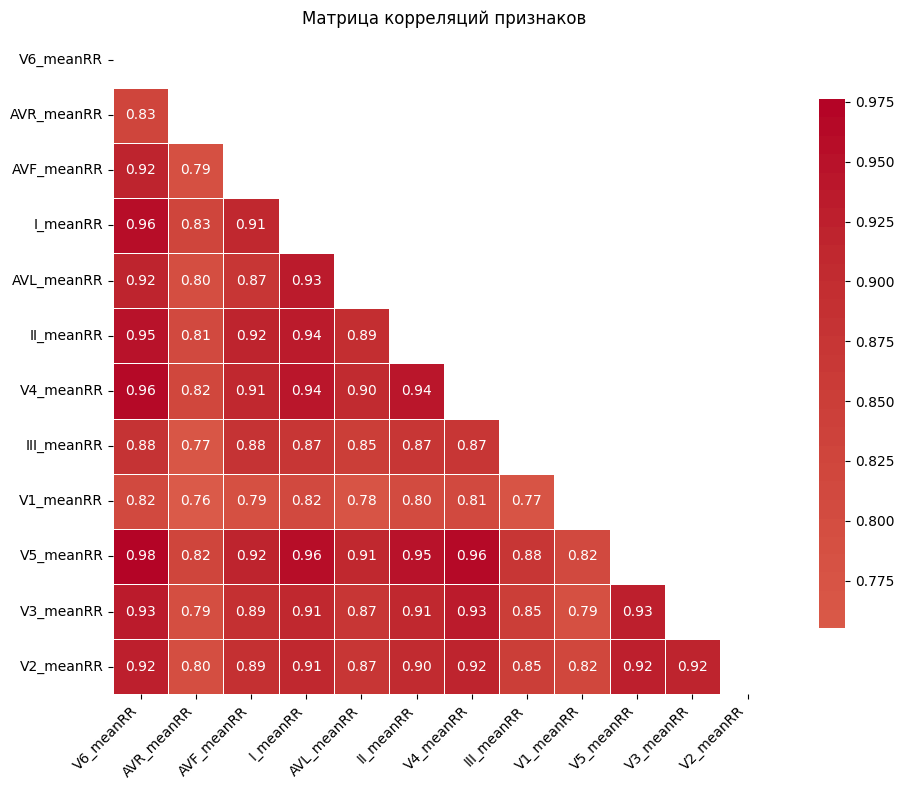

In [147]:
if len(meanr_list) > 0:
    figsize=(10, 8)
    # Вычисляем матрицу корреляций
    feature_corr = df[meanr_list].corr()

    print("Матрица корреляций:")
    print(feature_corr.round(3))

    # Визуализация матрицы корреляций
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))  # Верхний треугольник
    heatmap = sns.heatmap(feature_corr, mask=mask, annot=True, cmap='coolwarm',
                            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8},
                            linewidths=0.5)
    plt.title(f'Матрица корреляций признаков')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


else:
    print(f"Признаков с не найдено")

Создадим обобщенным признак 'meanRR_global'

In [148]:
df['meanRR_global'] = df[meanr_list].mean(axis=1)
numeric_columns = [col for col in numeric_columns if col not in meanr_list]
numeric_columns.append('meanRR_global')

/tmp/ipython-input-3125151986.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['meanRR_global'] = df[meanr_list].mean(axis=1)


In [149]:
analyze_correlations (df, numeric_columns)

Размер матрицы: (173, 173)

Матрица корреляций:
                    I_sdNN  I_RMSSD  I_PSD_mean_freq  I_PSD_std_freq  I_STFT_energy  I_PSD_power_mean  I_PSD_power_max  I_wavelet_E1  I_wavelet_E2  I_wavelet_E3  I_wavelet_E4  I_wavelet_E5  I_wavelet_entropy  I_SNR_dB  II_sdNN  II_RMSSD  II_PSD_mean_freq  II_PSD_std_freq  II_STFT_energy  II_PSD_power_mean  II_PSD_power_max  II_wavelet_E1  II_wavelet_E2  II_wavelet_E3  II_wavelet_E4  II_wavelet_E5  II_wavelet_entropy  II_SNR_dB  III_sdNN  III_RMSSD  III_PSD_mean_freq  III_PSD_std_freq  III_STFT_energy  III_PSD_power_mean  III_PSD_power_max  III_wavelet_E1  III_wavelet_E2  III_wavelet_E3  III_wavelet_E4  III_wavelet_E5  III_wavelet_entropy  III_SNR_dB  AVR_sdNN  AVR_RMSSD  AVR_PSD_mean_freq  AVR_PSD_std_freq  AVR_STFT_energy  AVR_PSD_power_mean  AVR_PSD_power_max  AVR_wavelet_E1  AVR_wavelet_E2  AVR_wavelet_E3  AVR_wavelet_E4  AVR_wavelet_E5  AVR_wavelet_entropy  AVR_SNR_dB  AVL_sdNN  AVL_RMSSD  AVL_PSD_mean_freq  AVL_PSD_std_freq  AVL_STFT